# Selección de clientes DynHybridFL - Método basado en recursos

En este notebook vamos a entrenar un modelo de ML utilizando el paradigma de Aprendizaje Federado [1] para los problemas de clasificación de dígitos manuscritos MNIST [2] y clasificación de imágenes a color CIFAR-10 [3]. Usaremos estos dos problemas de visión por computador para la implementación y análisis de rendimiento del método de selección de clientes basado en recursos Dyn-HybridFL que implementa una mejora de rendimiento frente a su algoritmo base HybridFL para la gestión dinámica del $T_\text{round}$.
> [1] https://arxiv.org/abs/1602.05629
>
> [2] http://yann.lecun.com/exdb/mnist
>
> [3] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [4] https://arxiv.org/abs/1905.07210

In [ ]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.4 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2587 sha256=daa874944b53bf74856bbb9aeddc3c7748697930cd8bd1f8cdb29c11059e14bd
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [ ]:
# install Torchsummary if not installed
try:
    import torchsummary
    print("torchsummary is installed.")
except:
    print("torchsummary is not installed.\nInstalling dependency torchsummary...")
    !pip install torchsummary

torchsummary is not installed.
Installing dependency torchsummary...


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy, title="Learning Curves"):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda'

# Cargar datasets - MNIST, CIFAR-10


## Distribución de los datos

Para la distribución de los datos preparamos una federación para ambos datasets en el que simulamos clientes __heterogéneos__ en cuestión tanto de clases como del tamaño de sus conjuntos de datos. Nos basamos en la federación que realizan en [1].

Para poder crear un escenario de clientes heterogéneos, suponemos un dataset de $10$ clases que puede ser cualquiera de los que estamos utilizando (MNIST o CIFAR-10). Luego realizamos una federación con la siguiente descripción de [1]: _"muestrear dos/diez clases para cada cliente para CIFAR-10/CIFAR-100 $^1$; Luego, para cada cliente $i$ y una clase seleccionada $c$, muestreamos $\alpha_{i,c} \sim U(.4, .6)$, y lo asignamos con $\frac{\alpha_{i,c}}{\sum_j{\alpha_{j,c}}}$ de los ejemplos para esta clase. Repetimos lo anterior para $10, 50$ y $100$ clientes."_ De esta forma, creamos una distribución de datos en el que cada cliente tendrán un número de clases diferente al resto y con diferentes tamaños, formando una distribución no-IID de datos.

> $^1$ En nuestro caso solo será para CIFAR-10 y MNIST, es decir, suponemos siempre $10$ clases.
>
> [1] https://arxiv.org/abs/2103.04628.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Para poder federar EMNIST, debemos de crear una configuración con `FedDatasetConfig` para poder especificar como queremos distribuir los datos y a cuántos nodos queremos federarlo y luego utilizar la clase `FedDataDistribution` para poder crear el dataset federado. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [ ]:
import math
import numpy as np

from copy import deepcopy
from torchvision import datasets, transforms
from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

K_mnist = 1000

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_mnist

# assign a sample proportion for each node-class pair (https://arxiv.org/abs/2404.06127)
num_classes = 10
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of MNIST
flex_dataset_mnist = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33131251.10it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1045363.65it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8208646.51it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4565187.82it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

Realizamos la misma serie de operaciones que con EMNIST, para el mismo número de clientes, $K = 1000$ (sin contar el servidor). Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

K_cifar = 1000

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_cifar

num_classes = 10

# assign a sample proportion for each node-class pair
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data),
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

100%|██████████| 170498071/170498071 [00:02<00:00, 72263674.14it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ unidades la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [ ]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
import torchsummary

torchsummary.summary(MLP((28, 28), 128).to(device), (1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Usaremos la red neuronal convolucional usada en la configuración experimental de HybridFL, que consiste en una CNN estándar que consiste en _"seis capas de convolución de 3 × 3 (con 32, 32, 64, 64, 128 y 128 canales, cada una de las cuales se activaba utilizando ReLU y se normalizaba por lotes, y cada dos de las cuales estaban seguidas de un max pooling de 2 × 2), seguidas de tres capas completamente conectadas (con 512 y 192 unidades activadas utilizando ReLU [2] y otras 10 unidades activadas utilizando soft-max)."_ [1].

> [1] https://arxiv.org/abs/1905.0721
>
> [2] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [ ]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).

    Model architecture taken from HybridFL experimental setting:
    - https://arxiv.org/abs/1905.07210
    """
    def __init__(self, in_channels: int, in_width: int = 32, in_height: int = 32, output_dim: int = 10):
        super(CNN, self).__init__()

        self.in_channels = in_channels
        self.input_w = in_width
        self.input_h = in_height
        self.num_classes = output_dim

        # Pooling Layer (applied every two layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First layer
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        output_w_1, output_h_1 = self.__conv_output_dims(
            self.input_w, self.input_h, 3, 1
        )

        # Second layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        output_w_2, output_h_2 = self.__conv_output_dims(
            output_w_1, output_h_1, 3, 1
        )

        # after pooling
        output_w_2, output_h_2 = self.__pool_output_dims(
            output_w_2, output_h_2, 2, 2
        )

        # Third layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        output_w_3, output_h_3 = self.__conv_output_dims(
            output_w_2, output_h_2, 3, 1
        )

        # Fourth layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        output_w_4, output_h_4 = self.__conv_output_dims(
            output_w_3, output_h_3, 3, 1
        )

        # after pooling
        output_w_4, output_h_4 = self.__pool_output_dims(
            output_w_4, output_h_4, 2, 2
        )

        # Fifth layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        output_w_5, output_h_5 = self.__conv_output_dims(
            output_w_4, output_h_4, 3, 1
        )

        # Sixth layer
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        output_w_6, output_h_6 = self.__conv_output_dims(
            output_w_5, output_h_5, 3, 1
        )

        # after pooling
        output_w_6, output_h_6 = self.__pool_output_dims(
            output_w_6, output_h_6, 2, 2
        )

        # Fully-Connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=int(output_w_6 * output_h_6 * 128), out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=self.num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # softmax applied on loss function
        return x

    def __conv_output_dims(self, width: int, height: int, kernel_size: int, padding: int = 1):
        output_w = width - kernel_size + 2 * padding + 1
        output_h = height - kernel_size + 2 * padding + 1
        return output_w, output_h

    def __pool_output_dims(self, width: int, height: int, kernel_size: int, stride: int = 1):
        output_w = np.floor((width - kernel_size) / stride) + 1
        output_h = np.floor((height - kernel_size) / stride) + 1

        return output_w, output_h

In [ ]:
torchsummary.summary(CNN(in_channels=3, output_dim=10).to(device), (3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 128, 8, 8]         147,584
      BatchNorm2d-14            [-1, 12

# Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

## Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje $^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(in_channels=cifar_in_channels, output_dim=cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

---
## Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [ ]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    print(server_flex_model.keys())
    return copy.deepcopy(server_flex_model)

## Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [ ]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


## Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [ ]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

## Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [ ]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        weights_per_layer = weights_per_layer.clone().detach().float().requires_grad_(True)   # ensure is floating-point type
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [ ]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

## Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [ ]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

## Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria (RandomSampling), similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [ ]:
from typing import Literal

Problem = Literal["mnist", "cifar"]

def train_n_rounds(pool: FlexPool, n_rounds: int, clients_per_round=20, problem: Problem = "mnist"):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train, transforms=transforms)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

# Selección de clientes con HybridFL

Ahora vamos a adaptar nuestro entorno de aprendizaje federado para utilizar el método de selección de clientes HybridFL [1].

HybridFL, así como otros algoritmos basados en recursos como FedCS [2] (del cual éste y muchos otros se basan), necesitan ser testeados bajo un entorno experimental que simule de forma realista y adecuada los requisitos de tiempo de reloj de cada una de las fases en aprendizaje federado. Tanto HybridFL como FedCS simulan cada uno de estos tiempos en un entorno dedicado de _Mobile Edge Computing_ (MEC) en el que hay un servidor central, denominado _Parameter Server_ o PS, una estación base o BS (que sirve de servidor en el eje o _edge server_), y una red de dispositivos móviles. En nuestro caso, podemos simular este entorno simplemente haciendo que las fases de entrenamiento como de subida de datos sean "agendadas" (_scheduled_), de manera que cumplan un cierto tiempo de reloj determinado antes de completarse. De esta manera, se verá reflejado el impacto que tendrá la estrategia de selección mediante la estimación de estos recursos.

---


## Inicialización de los recursos de los clientes

El siguiente paso para construir este entorno de simulación es determinar los recursos iniciales que tendrán los clientes. Los clientes son en esencia dispositivos (e.g. móviles, coches inteligentes, SmartTVs, ...) que tienen ciertas especificaciones que definen los recursos que posee. HybridFL así como FedCS, consideran dos tipos de recursos en los dispositivos:

- Recursos de comunicación inalámbrica: que influye directamente en la comunicación entre el servidor y los clientes (e.g ancho de banda en red, congestión de la red, _Resource Blocks_ $^1$). Podemos determinar la capacidad de comunicación de los clientes con el servidor en __cuánta cantidad de información es capaz de enviar en un segundo__, a lo que también se le conoce como _throughput_, y utilizamos como unidades estándar Mbit/s.

- Recursos computacionales: que influye en las actualizaciones del modelo en los clientes. HybridFL implementa el concepto de entrenamiento centralizado en el servidor; por tanto, como una suposición estándar en FL, suponemos que el servidor central tiene suficiente potencia computacional como para sobrepasar a los clientes en velocidad por la existencia de _stragglers_ [4]. Por lo que el tiempo de actualización de reloj del servidor la suponemos __nula o despreciable__. Podemos determinar la capacidad computacional de los clientes como __el número de ejemplos que puede procesar en un segundo__ actualizar el modelo [1].

- Permiso de subida de datos: este tipo de recurso, propio de HybridFL, es básicamente el permiso del cliente de subir sus datos al servidor, cuyo número de clientes se asume muy pequeño (menos del $\%1$ como mínimo [1]).

Por tanto, para poder muestrear en cada ronda de FL los recursos de los clientes, inicializamos primero las capacidades computacionales y de comunicación medias de cada cliente, de manera que en cada ronda se puedan samplear con una distribución Gaussiana truncada [5] como lo hacen los autores en [1]. Concretamente, el _throughput_ medio de los clientes se ha extraído de los experimentos hechos en un entorno simulado de comunicaciones inalámbricas de [1], en el que concluyeron que los clientes presentaban un _throughput_ de $\theta^{\text{avg}}_{k} = 1.4$ Mbit/s de media y un máximo de hasta $8.6$ Mbit/s, que resultan valores realistas en una red LTE. En cuanto a la capacidad computacional, se muestrea el número de datos procesados por segundo en entrenamiento de una distribución uniforme $\gamma^{\text{avg}}_{k} \sim U(10, 100)$. Finalmente, se elige de forma aleatoria y uniforme si el cliente $k$ permite su subida de datos en un ratio de $r_{\text{UL}} = 0.01$.

> $^1$ Aunque el número de bloques de recursos o RBs (la unidad mínima de ancho de banda en LTE [3]) puede influir significativamente en el tiempo de comunicación entre el servidor y los clientes, seguiremos la suposición de [2] por el que los RBs asignados a cada cliente son los mismos para todos, de esta manera solo nos preocupan factores más fluctuantes en casos reales como el ancho de banda.
>
> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333
>
> [3] _S. Sesia, M. Baker, and I. Toufik, LTE-the UMTS Long Term Evolution: From Theory to Practice. John Wiley & Sons, 2011_
>
> [4] G. Wang, C. Zhao, Q. Qi, R. Han, L. Bai and J. Choi, "Efficient Federated Learning via Joint Communication and Computation Optimization," in IEEE Transactions on Vehicular Technology, doi: 10.1109/TVT.2024.3379742.
>
> [5] https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [ ]:
from copy import deepcopy

# ratio of clients that permit their data to be uploaded
DEFAULT_R_UPLOAD = 0.01

# realistic client average throughput in Mbit/s
AVG_THROUGHPUT = 1.4

def init_client_resources(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    r_upload = kwargs["r_upload"] if "r_upload" in kwargs else DEFAULT_R_UPLOAD

    ## Computation capability - data samples per second
    avg_comp = np.random.uniform(10, 100)

    ## Communication capability - Mbit per second
    avg_thr = AVG_THROUGHPUT

    # client permits data upload
    data_upload = np.random.rand() < r_upload

    client_flex_model["avg_thr"] = avg_thr
    client_flex_model["avg_comp"] = avg_comp
    client_flex_model["data_upload"] = data_upload

    # save Nk
    client_flex_model["n_samples"] = len(client_data)

    # save amount of data for each class
    labels = client_data.to_numpy()[1]
    unique, counts = np.unique(labels, return_counts=True)
    client_flex_model["n_samples_per_class"] = dict(zip(unique, counts))

    # if client permit data to be uploaded, make their dataset public
    if data_upload:
        client_flex_model["public_data"] = client_data

## Petición de recursos

A continuación, implementamos la función `resource_request` en la que el servidor/agregador comunica a $\lceil K \times C \rceil$ clientes (siendo $K$ el total de clientes y $C$ la fracción de clientes a seleccionar por ronda) seleccionados aleatoriamente, a notificarle de los recursos que poseen para la ronda actual, así como notificarle si permiten su subida de datos al servidor. Esta tarea se realizará de la siguiente manera:

1. El servidor inicializará en su modelo de FLEX, un diccionario para cada recurso e información adicional, en el que las claves de los mismos será el identificador del cliente en cuestión.
2. Para cada cliente, se recuperará los valores medios de las capacidades computacionales (el número de ejemplos procesados por unidad de tiempo) y de comunicación (_throughput_), así como también si permiten su subida de los datos.
    - Con esta información, para el cliente en cuestión, se muestrea la capacidad computacional y de comunicación para la ronda actual de una distribución normal truncada (usamos la librería de `scipy` [1] para muestrear aleatoriamente de esta distribución) con los valores medios recuperados de los clientes $^1$. Para el muestreo de la distribución normal truncada se usa una variancia para ambos tipos de recursos de $r_{\text{var}} = 0.2$.
    - Finalmente, con los recursos muestreados para la ronda actual, se pueden calcular los tiempos estimados de actualización y subida: $t^{\text{UL}}_k$ y $t^{\text{UD}}_k$ respectivamente. Que se usarán tanto para la selección de clientes y de datos como para el entrenamiento y subida de modelos agendados.

Definimos además una función `get_model_size` que calcula el tamaño en bytes de un modelo de aprendizaje. Esto nos servirá para estimar el tiempo que tarda un cliente con cierto _throughput_ en subir un modelo mediante la siguiente formula:
$$t_{k}^{\text{UL}} = D_m / \theta_k^{(t)}$$

siendo $D_m$ el tamaño en Mbit del modelo, y $\theta_k^{(t)}$ el _throughput_ del cliente $k$ en la ronda $t$.

El tiempo estimado en actualizar un modelo en un cliente $k$ (i.e. entrenar un modelo) se calcula con la siguiente formula:
$$t_k^{\text{UD}} = \frac{E \times N_k}{\gamma_k^{(t)}}$$

siendo $E$ el número de épocas de entrenamiento, $N_k$ el número de ejemplos que posee el cliente $k$ y $\gamma_k^{(t)}$ el número de ejemplo procesados por unidad de tiempo para entrenar el modelo en el cliente $k$ en la ronda $t$.

> $^1$ Nótese que conceptualmente, este muestreo de la capacidad de comunicación y computacional del cliente es lo que este último realmente notifica al servidor y no sus valores medios.
>
> [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

In [ ]:
import sys
import torch.nn as nn

def get_model_size(model: nn.Module) -> int:
    """
    Get the size in bytes of a PyTorch learning model.
    """
    total_size = 0
    for param in model.parameters():
        total_size += param.numel() * param.element_size()

    return int(total_size)

In [ ]:
from typing import List
from scipy.stats import truncnorm

# loose for simulated capabilities
r_var = 0.2

def resource_request(agg_model: FlexModel, client_flex_models: List[FlexModel], **kwargs):
    """
    Requests resource capabilities and whether or not they permit their data to
    be uploaded for M selected clients randomly.
    """
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5

    # get model size in bytes
    if "model_size" in agg_model.keys():
        model_size = agg_model["model_size"]
    else:
        model_size = get_model_size(agg_model["model"])

        # store model size in server model
        agg_model["model_size"] = model_size


    # indexed resources for each selected client saved in the aggregator
    agg_model["comp_resources"] = {}
    agg_model["comm_resources"] = {}
    agg_model["client_t_update"] = {}
    agg_model["client_t_upload"] = {}
    agg_model["permit_data_upload"] = {}
    agg_model["client_data"] = {}
    agg_model["client_n_samples_per_class"] = {}

    for k in client_flex_models:
        # get client average computational and communications capabilities
        avg_comp_cap = client_flex_models[k]["avg_comp"]
        avg_thr = client_flex_models[k]["avg_thr"]
        permit_data_upload = client_flex_models[k]["data_upload"]

        ## Computational capability - data samples processed per second to train
        std_dev_comp = 0.1 * avg_comp_cap

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_comp_cap, (1 + r_var) * avg_comp_cap
        a = (a - avg_comp_cap) / std_dev_comp
        b = (b - avg_comp_cap) / std_dev_comp

        comp_cap = truncnorm.rvs(a, b, loc=avg_comp_cap, scale=std_dev_comp, size=1)[0]

        # compute estimated update time
        n_samples = client_flex_models[k]["n_samples"]
        t_update = (epochs * n_samples) / comp_cap

        ## Communication capability - Mbit per second
        std_dev_thr = 0.1 * avg_thr

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_thr, (1 + r_var) * avg_thr
        a = (a - avg_thr) / std_dev_thr
        b = (b - avg_thr) / std_dev_thr

        comm_cap = truncnorm.rvs(a, b, loc=avg_thr, scale=std_dev_thr, size=1)[0]

        # compute estimated upload time in seconds
        t_upload = (model_size * 8) / (comm_cap * 1_000_000)

        # save resource capabilities for client k in current round
        agg_model["comp_resources"][k] = comp_cap
        agg_model["comm_resources"][k] = comm_cap

        # save estimated update and upload times
        agg_model["client_t_update"][k] = t_update
        agg_model["client_t_upload"][k] = t_upload

        # also save estimated times in clients to simulate scheduled training
        client_flex_models[k]["t_update"] = t_update
        client_flex_models[k]["t_upload"] = t_upload

        ## Client Data
        if permit_data_upload:
            agg_model["client_data"][k] = client_flex_models[k]["public_data"]

        # set data upload permit
        agg_model["permit_data_upload"][k] = permit_data_upload

        ## Amount of data for each class
        agg_model["client_n_samples_per_class"][k] = client_flex_models[k]["n_samples_per_class"]

## Selección de clientes

La selección de los clientes es un algoritmo de tipo _greedy_ en el que se busca maximizar el número de clientes seleccionados $𝕊$ sujeto a un cierto _deadline_ de tiempo por ronda $T_\text{round}$:
$$
\max |𝕊| \\
\text{s.t.} \ T_\text{round} \ge T_\text{cs} + T_{𝕊}^{\text d} + \Theta_{|𝕊|} + T_\text{agg}
$$
siendo $T_\text{cs}$ el tiempo de selección de clientes, $T_{𝕊}^{\text d}$ el tiempo de distribución del modelo global a los clientes seleccionados, $\Theta_{|𝕊|}$ el tiempo transcurrido desde el inicio de la actualización de los modelos hasta que el $k_i$-ésimo cliente haya actualizado y subido sus parámetros al servidor (más información en como se calcula este tiempo en [1]) y $T_\text{agg}$ el tiempo que toma al servidor agregar los parámetros de los clientes.

Como en [1] y [2], nosotros suponemos que el servidor tiene vastos recursos y que por tanto los tiempos de selección y agregación son despreciables: $T_\text{cs} = T_\text{agg} = 0$.

El algoritmo de selección en HybridFL [2] varía del de FedCS [1] en cuanto a que en el primero se elige el cliente con tiempo estimado mínimo mientras que en [1] se elige el que tenga la inversa del tiempo máximo. Como podemos darnos cuenta las dos formas son equivalentes. En nuestro caso optamos por la minimización de la función (i.e. elegir el cliente con menor tiempo estimado agregado). En HybridFL [2], esta función de tiempo transcurrido si se incluye el cliente $k$ al conjunto de seleccionados se le denomina $T_{\text{inc}}(𝕊, k)$.

En [2] además, se elige el cliente con $T_{\text{inc}}$ menor multiplicado por un coeficiente de variación $CV(N_r)$ que penaliza la función a minimizar si los datos de los clientes tienen un alto nivel de desbalance entre clases, de manera que se pueda sanitizar el problema de datos No-IID en los clientes en esa ronda de selección. Mas información sobre como calcular este coeficiente en [2].

> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333

---

Para poder implementar la selección de los clientes, tenemos primero que definir:
1. Por un lado, una función que calcule el tiempo de distribución del modelo a cada cliente.
2. Una función para calcular el tiempo estimado transcurrido si incluimos un cliente $k$ al conjunto de clientes seleccionados $𝕊$, $T_{\text{inc}}(𝕊, k)$.
3. Y por último, una función para calcular el coeficiente de variación $CV(N_r)$.

En el caso de $T_\text{round}$ esta será calculada por cada llamada a `client_selection` que dependerá de los recursos de los clientes actuales y los de la ronda anterior. Esta característica es el factor diferencial con HybridFL convencional, dando lugar a Dyn-HybridFL.

Para el _deadline_ de ronda inicial $T_\text{round}^{(0)}$, utilizamos el $T_\text{round}$ usado en el algoritmo HybridFL de $3$ minutos como punto inicial.

In [ ]:
def T_model_dist(model_size: int, throughputs: list):
    """
    Computes the estimated time it takes to distribute the model to all clients synchronically.

    If throughputs is empty, then time is 0 (no clients to distribute to).
    """
    if not throughputs:
        return 0

    res = (model_size * 8) / (min(throughputs) * 1_000_000)
    return res

In [ ]:
def T_inc(agg_model: FlexModel, S: set, k: int, elapsed_time: int):
    """
    Computes estimate elapsed time when client k is included to selected set of clients S.
    """
    t_upload = agg_model["client_t_upload"][k]
    t_update = agg_model["client_t_update"][k]

    # get model size to estimate dist time
    model_size = agg_model["model_size"]

    # throughputs of clients in S
    S_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # throughputs of clients in S + {k}
    S_plus_k_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S or client == k]

    return T_model_dist(model_size, S_plus_k_thr) - T_model_dist(model_size, S_thr) + t_upload + max(0, t_update - elapsed_time)

In [ ]:
def CV(agg_model: FlexModel, S: set, classes: list):
    """
    Computes the coefficient of variation of data samples per class in clients in set S.
    """
    # get total number of data samples per class
    Nr = {}
    for k in agg_model["client_n_samples_per_class"]:
        if k not in S:
            continue

        k_counts = agg_model["client_n_samples_per_class"][k]
        Nr = {key: Nr.get(key, 0) + k_counts.get(key, 0) for key in set(Nr) | set(k_counts)}

    # fill up for all classes
    Nr = {key: Nr.get(key, 0) for key in classes}

    L = len(classes)
    n_mean = sum(Nr.values()) / L

    # compute the variance of the amount of data per class
    variance = sum((n_l - n_mean)**2 for n_l in Nr.values()) / L

    # return the coefficient of variance with respect to the mean
    return variance / n_mean

In [ ]:
from flex.data import Dataset
from statistics import mean

DEFAULT_T_ROUND = 3 * 60

def client_selection(agg_model: FlexModel, agg_data: Dataset):
    ## compute T_round
    # compute current phi
    mean_t_update = mean(list(agg_model["client_t_update"].values()))
    mean_t_upload = mean(list(agg_model["client_t_upload"].values()))

    phi = mean_t_update + mean_t_upload

    # retrieve previous phi or same current phi if it's first round
    prev_phi = agg_model["current_phi"] if "current_phi" in agg_model.keys() else phi

    # update current phi
    agg_model["current_phi"] = phi

    # retrieve previous t_round
    prev_t_round = agg_model["current_t_round"] if "current_t_round" in agg_model.keys() else DEFAULT_T_ROUND

    # change t_round dynamically by speed up on the previous phi
    speed_up = phi / prev_phi
    t_round = prev_t_round * speed_up

    # update current t_round
    agg_model["current_t_round"] = t_round

    print("Previous T round:", prev_t_round)
    print("Current T round:", t_round)

    # stats for t_round
    agg_model["max_tround"] = max(agg_model["max_tround"] if "max_tround" in agg_model.keys() else 0, t_round)
    agg_model["min_tround"] = min(agg_model["min_tround"] if "min_tround" in agg_model.keys() else 1_000_000, t_round)
    print("Max T round:", agg_model["max_tround"])
    print("Min T round:", agg_model["min_tround"])

    ## Client selection
    # get classes of the ML task
    classes = agg_model["classes"]

    # get client indices
    Kp = set(agg_model["comp_resources"].keys())

    # initialize set of selected clients to train locally
    S = set()

    # initialize time budget
    t = 0

    # function to minimize
    def f(x):
        return T_inc(agg_model, S, x, t)

    while len(Kp) > 0:
        x = min(Kp, key=lambda k: f(k) * CV(agg_model, S | {k}, classes))

        # remove selected from Kp
        Kp.remove(x)

        # check time deadline
        tp = t + T_inc(agg_model, S, x, t)
        if tp < t_round:
            # add client if time deadline is met
            t = tp
            S.add(x)

    return S

## Selección de datos

En esta fase, el servidor recupera todos los datos de los clientes que permitieron la subida de sus datos $D_u$, y el servidor entonces selecciona los ejemplos según un criterio de selección que depende del _deadline_ $t^\text{UD}$, que es el tiempo decidido para el que cuentan los clientes en subir sus datos antes de que el primer cliente en actualizar el modelo suba sus parámetros. En HybridFL [1], se proponen dos formas de seleccionar los datos que conforman el conjunto de datos final $D^\text{UL}$ para el que el servidor actualiza el modelo global:
1. El primero es seleccionar de manera _greedy_ los ejemplos del cliente con mayor _throughput_ en orden.
2. En el segundo, el servidor intenta construir un conjunto de datos IID de la misma forma que en el primero solo que en vez de hacerlo en orden, lo hace por clase, de manera que se distribuyan los datos de manera idéntica. El dataset $D^\text{UL}$ ya cuenta con la propiedad de ser uniformemente distribuído por haber seleccionado los clientes de forma aleatoria en la fase de __Petición de Recursos__.

> [1] https://arxiv.org/abs/1905.07210

In [ ]:
import gc
from flex.data import Dataset

def data_selection(agg_model: FlexModel, agg_data: Dataset, **kwargs):
    S = kwargs["S"]

    # get clients that permit their data to be uploaded and they are not selected to train
    U = [u for u in agg_model["permit_data_upload"] if agg_model["permit_data_upload"][u] and u not in S]

    print(f"Number of clients in U: {len(U)}")

    t_upload_deadline = min(agg_model["client_t_update"].values())

    classes = agg_model["classes"]

    # masks to skip samples indices from client data
    removal_masks = {u: [] for u in agg_model["client_data"]}

    def client_has_class(k: int, label: int):
        labels = agg_model["client_data"][k].to_numpy()[1]

        # remove already taken samples
        removal_mask = removal_masks[k]
        filtered_classes = np.delete(labels, removal_mask, axis=0)

        res = filtered_classes[filtered_classes == label].size > 0

        return res

    def empty_client_data():
        samples = []
        for u in U:
            d_x, d_y = agg_model["client_data"][u].to_numpy()
            filtered_d_x = np.delete(d_x, removal_masks[u], axis=0)
            filtered_d_y = np.delete(d_y, removal_masks[u], axis=0)
            samples.append(filtered_d_x.size)

        return sum(samples) == 0

    D_ul_X = []
    D_ul_y = []
    flag = True
    t_data_upload = 0

    while flag:
        print("Time upload:", t_data_upload)

        for l in classes:
            # get client with maximum throughput with class l samples
            x = max([u for u in U if client_has_class(u, l)], key=lambda k: agg_model["comm_resources"][k], default=None)

            # if there's no client with l class, just continue with the other class
            if not x:
                # check if there's data before continuing to avoid infinite loop
                flag = not empty_client_data()
                continue

            d_x, d_y = agg_model["client_data"][x].to_numpy()

            # filter data with label l
            mask = np.where(d_y == l)[0].tolist()

            # filter already taken samples
            mask = [i for i in mask if i not in removal_masks[x]]

            # take next first sample of class l
            d = d_x[mask][0]

            # compute data upload time
            u_thr = agg_model["comm_resources"][x]
            D_sample = d.nbytes + np.array(l).nbytes   # size of sample

            t_u = (D_sample * 8) / (u_thr * 1_000_000)

            if (t_data_upload + t_u) <= t_upload_deadline:
                # add d to D_ul
                D_ul_X.append(d)
                D_ul_y.append(l)

                # remove d from D_ul
                removal_masks[x].append(mask[0])

            # check deadline
            if (t_data_upload + t_u) >= t_upload_deadline:
                flag = False

            # finish if clients data are empty
            if empty_client_data():
                flag = False
                break

            # update data upload time
            t_data_upload += t_u

        # security check when not found any more data and didn't check deadline
        if t_data_upload >= t_upload_deadline:
            flag = False

    return np.array(D_ul_X), np.array(D_ul_y)

## Distribución del modelo global

Redefinimos la subrutina de `copy_server_model_to_clients` visto en la configuración básica, para copiar solo la información que deben de compartir los clientes con el servidor, es decir, no debemos distribuir la información almacenada propia del servidor a los clientes y solo la que nos interesa. Esto viene a darse porque FLEX por defecto copia el modelo del servidor entero, y por tanto se copiaría los datos de los clientes $D_u$, información de los recursos de todos los clientes, etc.

Para solo distribuir la información que nos interesa a los clientes, distribuimos toda la información del servidor para las claves que estén en la lista de claves de distribución (_white list_).

In [ ]:
from flex.pool import deploy_server_model
import copy

white_list = [
    "model",
    "criterion",
    "optimizer_func",
    "optimizer_kwargs"
]

@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    white_listed = {key: value for key, value in server_flex_model.items() if key in white_list}
    return copy.deepcopy(white_listed)

Creamos una subrutina del servidor para poder simular el tiempo de distribución de los modelos a los clientes. Esta función pretende ser ejecutada _luego_ o _antes_ de copiar el servidor del modelo a los clientes.

In [ ]:
import time
from tqdm import tqdm
from flex.pool import FlexPool
from flex.data import Dataset

def scheduled_model_distribution(agg_model: FlexModel, _: Dataset, **kwargs):
    # get model size
    model_size = agg_model["model_size"]

    # get selected clients
    S: set = kwargs["S"]

    # get client throughputs
    thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # compute Time of Distribution
    t_dist = T_model_dist(model_size, thr)

    # simulate Time of Distribution of the model by sleeping
    with tqdm(total=t_dist, desc="Distributing model...") as pbar:
        interval = 0.1
        for _ in range(int(t_dist / interval)):
            time.sleep(interval)
            pbar.update(interval)

## Actualización y subida del modelo agendado

Como hemos explicado anteriormente, para simular el tiempo que se estima en la actualización del modelo en los clientes, definimos la función de entrenamiento `scheduled_train` el cual entrena de la manera convencional que hemos visto en la configuración básica del entorno FL, pero esta vez, el tiempo transcurrido de esta función está sujeto a cumplir el tiempo de actualización para ese cliente como mínimo. De manera que se refleje el impacto de la selección de tal cliente en la duración total del entrenamiento del modelo global.

Los clientes cuando terminan de entrenar su modelo, inmediatamente lo suben al servidor, por lo que también simularemos la subida agendada del modelo actualizado por el cliente en esta función simplemente _durmiendo_ el hilo de ejecución sobre su tiempo de subida $t^{UL}_k$.

In [ ]:
import time

def scheduled_train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get scheduled update and upload time
    t_update = client_flex_model["t_update"]
    t_upload = client_flex_model["t_upload"]

    # start timer
    start = time.time()

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # stop timer and get effective training time
    end = time.time()
    training_time = end - start

    # simulate scheduled updating and uploading time by sleeping
    time.sleep(max(0, t_update - training_time) + t_upload)

En cuanto a la actualización del modelo de forma centralizada en el servidor con la función `centralized_train`, donde realizamos el mismo bucle de entrenamiento pero en este caso _sin agendar_, debido a que hemos supuesto que el tiempo de entrenamiento del servidor era despreciable comparado con los cliente, y que por tanto no tendría ningún impacto en el tiempo transcurrido de entrenamiento federado. También, ante la posibilidad de que no se haya podido recuperar datos del cliente (e.g. $U = 0$), indicamos con un campo booleano si el servidor ha podido actualizar el modelo o no; para de esta manera saber _a posteriori_ si agregamos los pesos del servidor si y solo si son nuevos parámetros. En cuanto a su tiempo de subida, es evidente que $t^{UL}_\text{server} = 0$ puesto que los parámetros están ya en el servidor.

In [ ]:
def centralized_train(server_model: FlexModel, _test_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data
    X, y = kwargs["client_data"]

    if y.size == 0:
        # model has not been updated by server
        server_model["trained"] = False
        return

    client_data = Dataset.from_array(X, y)

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = server_model["model"]
    optimizer = server_model["optimizer_func"](
        model.parameters(), **server_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = server_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # server has updated the model
    server_model["trained"] = True

El hilo de ejecución de los clientes se realiza en manera paralela y no secuencial tanto para la actualización de los modelos como su subida. Sin embargo, FedCS (y por tanto HybridFL) establece que las subidas de los modelos se realizan de manera síncrona y secuencial; por tanto, para simular el tiempo que debería durar la actualización y subida de los modelos vamos a definir una función en la que el servidor _duerme_ su hilo de ejecución por el tiempo necesario para simular la actualización paralela y la subida secuencial de los modelos, es decir, el tiempo transcurrido $\Theta_{S_t}$ [1]. En caso de que la ejecución en paralelo haya tomado más tiempo que $\Theta_{S_t}$, simplemente no dormimimos el hilo de ejecución.

> [1] Detalles en cómo calcular $\Theta_{S_t}$ en https://arxiv.org/abs/1804.08333.

In [ ]:
import time
from flex.pool import FlexPool
from flex.data import Dataset

def simulate_model_update_upload(server_model: FlexModel, _: Dataset, **kwargs):

    # function to compute the time elapsed of clients parallel training and sequential upload
    def compute_simulation_time(S: list, elapsed_time=0):
        k = S[0]
        theta = elapsed_time + server_model["client_t_upload"][k] + max(0, server_model["client_t_update"][k] - elapsed_time)

        if len(S) == 1:
            return theta

        return compute_simulation_time(S[1:], elapsed_time=theta)

    # get clients indices
    S = list(kwargs["S"])

    # get total upload time
    elapsed_training_time = kwargs["training_time"]

    # compute the time of sequential model uploads and parallel updates
    sim_time = compute_simulation_time(S)

    # sleep for the difference between the parallel and sequential total times
    time_to_sleep = sim_time - elapsed_training_time

    if time_to_sleep > 0:
        time.sleep(time_to_sleep)

## Recolección de las actualizaciones de los modelos

Por último cambiamos la función de obtención y agrupación de los pesos de los clientes para también incluir también los del servidor.

In [ ]:
import time
import torch
import numpy as np

def collect_server_and_clients_weights(aggregator_flex_model: FlexModel, clients_flex_models: List[FlexModel], **kwargs):

    def get_model_weights(client_flex_model: FlexModel):
        """
        Returns the weights of a Flex model per layer.
        """
        weight_dict = client_flex_model["model"].state_dict()
        return [weight_dict[name] for name in weight_dict]

    if "weights" not in aggregator_flex_model:
        aggregator_flex_model["weights"] = []

    # collect clients weights
    for k in clients_flex_models:
        client_weights = get_model_weights(clients_flex_models[k])
        aggregator_flex_model["weights"].append(client_weights)

    # finally collect server weights if server has trained with client data
    if aggregator_flex_model["trained"]:
        server_weights = get_model_weights(aggregator_flex_model)
        aggregator_flex_model["weights"].append(server_weights)

## Entrenamiento paralelo de los modelos

Cuando no tenemos restricciones de tiempo ni fases agendadas, es viable realizar las actualizaciones locales de los clientes de forma _iterativa_, i.e. una actualización tras de otra. Sin embargo, para poder simular de la manera más cercana a la realidad el entrenamiento en cada ronda y que los resultados sean acordes a partir de los datos y recursos de los clientes, necesitamos hacer que _al menos_ las actualizaciones de los modelos locales en los clientes se realicen de forma paralela. Esto no solo se necesita para obtener resultados coherentes con la configuración establecida, sino que también es necesario para que el entrenamiento sea viable computacionalmente; esto debido a que algunos clientes pueden tomar hasta $> 30$ segundos en actualizar un modelo, algo que puede retrasar el entrenamiento de otro en el caso de hacerse de forma iterativa y síncrona.

Solo necesitaremos de paralelizar las actualizaciones en los clientes. Las demás fases como la subida de los parámetros locales, la distribución del modelo, la agregación de las actualizaciones, etc. Si se han de realizar de forma síncrona. En [1] muestran resultados del estado del arte en aprendizaje distribuído utilizando una aproximación síncrona.

Para entonces poder paralelizar este entrenamiento, creamos una clase `FlexParallelPool` que hereda de la clase de FLEX `FlexPool`. Con esto, definimos un método `parallel_map` que realice la misma tarea que `map` (que es aplicar una función a un conjunto de actores destino), pero en este caso de forma paralela, creando para cada actor destino un hilo de ejecución. De esta manera lograremos paralelizar la función `scheduled_train` de los clientes y así poder simular el entrenamiento en paralelo de una forma más realista.

> [1] https://arxiv.org/abs/1604.00981

In [ ]:
import threading
from typing import Callable


class FlexParallelPool(FlexPool):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def parallel_map(self, func: Callable, dst_pool: FlexPool = None, **kwargs):
        if dst_pool is None:
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), self._data.get(i)), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        elif FlexPool.check_compatibility(self, dst_pool):
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), dst_pool._models), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        else:
            raise ValueError(
                "Source and destination pools are not allowed to comunicate, ensure that their actors can communicate."
            )

## Training Loop final

Finalmente, implementamos la función de entrenamiento en aprendizaje federado en el que aplicamos todas las funciones que realizan la selección de clientes con HybridFL. Este bucle de entrenamiento recibe un límite de tiempo $T_\text{final}$ para el cual el bucle termina cuando haya transcurrido esta cantidad de tiempo en segundos.

In [ ]:
import time
import gc

from flex.pool import FlexPool

MNIST_LABELS = list(set(train_data.targets))
CIFAR_LABELS = list(set(train_data.targets))

def train_n_rounds_hybrid(pool: FlexParallelPool, T_final: int, clients_per_round: int = 100, problem: Problem = "mnist"):
    """
    FL training loop for a certain deadline time in seconds.
    """
    # collect garbage
    gc.collect()

    # save list of classes to server model to use them in client and data selection
    def set_classes_to_server(flex_model: FlexModel, _):
        flex_model["classes"] = MNIST_LABELS if problem == "mnist" else CIFAR_LABELS

    pool.servers.map(set_classes_to_server)

    # select transformations depending on problem to solve and assign to server
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    # initialize clients simulated resources
    pool.clients.map(init_client_resources)

    losses = []
    accuracies = []
    elapsed_round_times = []
    total_selected = 0

    start = time.time()
    end = start
    i = 0
    while (end - start) < T_final:
        start_round = time.time()
        print(f"\nRunning round: {i+1} - Time elapsed: {end - start} seconds")

        # Resource Request: ask M random clients to participate in the current round
        # and clients notify the server about their resources and whether or not the permit
        # their data to be uploaded (set U of clients)
        print("Server requesting clients resources...")
        random_clients_pool = pool.clients.select(clients_per_round)
        random_clients = random_clients_pool.clients

        pool.aggregators.map(resource_request, random_clients)

        # Client selection from Kp
        print("Server selecting clients to train locally...")
        S = pool.aggregators.map(client_selection)[0]
        print(f"Selected clients (S): {len(S)} out of {clients_per_round}")

        # Update total selected clients
        total_selected += len(S)

        # Data selection from U clients
        print("Server selecting data to train centralized...")
        client_data = pool.aggregators.map(data_selection, S=S)[0]
        print(f"Selected data length (|D_UL|): {client_data[0].size}")

        # get selected clients pool
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in S)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        print("Distributing model...")
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # schedule the distribution of the model
        pool.servers.map(scheduled_model_distribution, S=set(S))

        # Each selected client trains their model obeying the time restrictions
        start_update_upload = time.time()
        print("Scheduled model update and upload...")
        FlexParallelPool(selected_clients._data,
                         selected_clients._actors,
                         selected_clients._models).parallel_map(scheduled_train, transforms=transforms)
        end_update_upload = time.time()

        # simulate sequential model upload
        pool.servers.map(simulate_model_update_upload, training_time=(end_update_upload - start_update_upload), S=S)

        # compute local training time in total
        total_training_time = time.time() - start_update_upload
        print(f"Scheduled model update and upload time: {total_training_time} sec")

        # Server updates model from clients uploaded data
        print("Centralized model update...")
        pool.servers.map(centralized_train, client_data=client_data, transforms=transforms)

        # The aggregator collects weights from the selected clients and aggregates them
        print("Collecting weights...")
        pool.aggregators.map(collect_server_and_clients_weights, selected_clients)

        print("Aggregating global model...")
        pool.aggregators.map(aggregate_with_fedavg)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)

        end = time.time()
        elapsed_round_times.append(end - start_round)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}, round time: {end - start_round}")

        i += 1

    print(f"Total clients selected: {total_selected}")
    return losses, accuracies, elapsed_round_times

In [ ]:
import pandas as pd
import pickle

def save_data(pool, losses, accuracies, elapsed, filename):
    df = pd.DataFrame({
        "loss": losses,
        "accuracy": accuracies,
        "elapsed_time": elapsed
    })

    # save data for MNIST
    df.to_csv(f"{filename}.csv", index=False)

    display(df)

    # save model
    with open(f"{filename}_model.pkl", "wb") as out:
        pickle.dump(pool, out)

In [ ]:
from flex.pool import FlexPool

# Setup
T_FINAL_MIN = 400    # 400 minutes of FL training (~ 6 hours)
C = 0.1              # fraction of participant clients per round

pool_mnist = FlexParallelPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)
pool_cifar = FlexParallelPool.client_server_pool(flex_dataset_cifar, init_func=build_server_model_cnn)

print(f"MNIST config: {len(pool_mnist.servers)} servers and {len(pool_mnist.clients)} clients)")
print(f"CIFAR-10 config: {len(pool_cifar.servers)} servers and {len(pool_cifar.clients)} clients)")

MNIST config: 1 servers and 1000 clients)
CIFAR-10 config: 1 servers and 1000 clients)



Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180
Current T round: 180.0
Max T round: 180.0
Min T round: 180.0
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8852149236418247 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 187.33833408355713 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.6384, test loss: 1.7773, round time: 194.7284607887268

Running round: 2 - Time elapsed: 194.7284619808197 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0
Current T round: 169.31711708645062
Max T round: 180.0
Min T round: 169.31711708645062
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.7292331126467637 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.60888934135437 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.7998, test loss: 1.1115, round time: 167.9102602005005

Running round: 3 - Time elapsed: 362.64044213294983 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.31711708645062
Current T round: 173.19362736512903
Max T round: 180.0
Min T round: 169.31711708645062
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.835227396038393 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.58196640014648 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8249, test loss: 0.8136, round time: 180.0093173980713

Running round: 4 - Time elapsed: 542.6513328552246 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.19362736512903
Current T round: 180.07923970074765
Max T round: 180.07923970074765
Min T round: 169.31711708645062
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.834334683560194 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.47436952590942 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8446, test loss: 0.6493, round time: 190.92282032966614

Running round: 5 - Time elapsed: 733.5756812095642 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.07923970074765
Current T round: 166.51238733862516
Max T round: 180.07923970074765
Min T round: 166.51238733862516
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05204021868104077
Time upload: 0.10408043736208154
Time upload: 0.1509166341750182
Time upload: 0.19775283098795476
Time upload: 0.23938500593278728
Time upload: 0.27060913714141177
Time upload: 0.29662924648193223
Time upload: 0.3070372902181404
Selected data length (|D_UL|): 47040
Selected clients for this round: 69
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.7350336704854215 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.67489671707153 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8579, test loss: 0.5643, round time: 168.47862696647644

Running round: 6 - Time elapsed: 902.0560767650604 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.51238733862516
Current T round: 174.4947818768429
Max T round: 180.07923970074765
Min T round: 166.51238733862516
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8822863761598545 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.12991213798523 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8645, test loss: 0.5110, round time: 185.56322479248047

Running round: 7 - Time elapsed: 1087.621420621872 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.4947818768429
Current T round: 167.1793817586919
Max T round: 180.07923970074765
Min T round: 166.51238733862516
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.870871545580685 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 164.5709261894226 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8697, test loss: 0.4602, round time: 170.96700143814087

Running round: 8 - Time elapsed: 1258.5900292396545 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.1793817586919
Current T round: 170.88156030044667
Max T round: 180.07923970074765
Min T round: 166.51238733862516
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9070205784352856 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 164.66572761535645 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8754, test loss: 0.4356, round time: 171.20525693893433

Running round: 9 - Time elapsed: 1429.7968056201935 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.88156030044667
Current T round: 161.54402898418684
Max T round: 180.07923970074765
Min T round: 161.54402898418684
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04611185217586613
Time upload: 0.0922237043517323
Time upload: 0.13833555652759846
Time upload: 0.18444740870346452
Time upload: 0.22133689044415736
Time upload: 0.249004001749677
Time upload: 0.26283755740243686
Time upload: 0.2674487426200235
Time upload: 0.2720599278376101
Selected data length (|D_UL|): 47040
Selected clients for this round: 6

Distributing model...:  99%|█████████▉| 2.800000000000001/2.831034936175245 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 155.38313150405884 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8794, test loss: 0.4174, round time: 162.20562410354614

Running round: 10 - Time elapsed: 1592.0039103031158 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 161.54402898418684
Current T round: 157.33879057487616
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.781479224002645 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 158.0194206237793 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8835, test loss: 0.4116, round time: 164.2964804172516

Running round: 11 - Time elapsed: 1756.301991701126 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 157.33879057487616
Current T round: 166.96501766731245
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.879591226835595 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.58831143379211 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8873, test loss: 0.3917, round time: 174.0024721622467

Running round: 12 - Time elapsed: 1930.30619597435 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.96501766731245
Current T round: 179.84242405408895
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.7117798311334935 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 188.91725039482117 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8895, test loss: 0.3854, round time: 195.2620027065277

Running round: 13 - Time elapsed: 2125.5698029994965 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.84242405408895
Current T round: 160.53405390311872
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.756835034171399 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.0231590270996 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8905, test loss: 0.3803, round time: 167.3712034225464

Running round: 14 - Time elapsed: 2292.9424850940704 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 160.53405390311872
Current T round: 172.80212843062614
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04880046424768139
Time upload: 0.09760092849536275
Time upload: 0.14152134631827598
Time upload: 0.18056171771642107
Time upload: 0.21472204268979803
Time upload: 0.24400232123840684
Time upload: 0.2732825997870157
Selected data length (|D_UL|): 47040
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8826151359890346 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 170.4367218017578 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8914, test loss: 0.3612, round time: 177.31666111946106

Running round: 15 - Time elapsed: 2470.260663509369 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.80212843062614
Current T round: 172.88225164144689
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.728915664561896 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.63476300239563 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8951, test loss: 0.3536, round time: 178.90140008926392

Running round: 16 - Time elapsed: 2649.163618326187 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.88225164144689
Current T round: 158.18099071674573
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8893312928428543 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 154.8388159275055 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8965, test loss: 0.3473, round time: 161.13856077194214

Running round: 17 - Time elapsed: 2810.3038387298584 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 158.18099071674573
Current T round: 179.99261827618136
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.7386124876408364 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.24099850654602 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8973, test loss: 0.3543, round time: 186.4321575164795

Running round: 18 - Time elapsed: 2996.737514734268 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.99261827618136
Current T round: 166.82793338256016
Max T round: 180.07923970074765
Min T round: 157.33879057487616
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.042334265909479134
Time upload: 0.08466853181895827
Time upload: 0.1282102735142475
Time upload: 0.17295949099534683
Time upload: 0.21891618426225626
Time upload: 0.2660803533149757
Time upload: 0.31324452236769496
Time upload: 0.3628236429920344
Time upload: 0.40635086200609827
Time upload: 0.44443717864340415
Time upload: 0.48252349528071004
Tim

Distributing model...:  97%|█████████▋| 2.700000000000001/2.7817656895439384 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 163.9358208179474 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8994, test loss: 0.3492, round time: 171.57196974754333

Running round: 19 - Time elapsed: 3168.3108880519867 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.82793338256016
Current T round: 156.2331459729133
Max T round: 180.07923970074765
Min T round: 156.2331459729133
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05002904737121234
Time upload: 0.10005809474242464
Time upload: 0.14508423737651568
Time upload: 0.1851074752734855
Time upload: 0.2201278084333341
Time upload: 0.2501452368560615
Time upload: 0.28016266527878886
Selected data length (|D_UL|): 47040
Selected clients for this round: 64
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.853693036410565 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 156.4392774105072 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8995, test loss: 0.3544, round time: 163.22318410873413

Running round: 20 - Time elapsed: 3331.535541534424 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 156.2331459729133
Current T round: 170.59659012525233
Max T round: 180.07923970074765
Min T round: 156.2331459729133
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7430782379210967 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.7384271621704 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9006, test loss: 0.3345, round time: 180.03175377845764

Running round: 21 - Time elapsed: 3511.5686407089233 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.59659012525233
Current T round: 175.82304606014603
Max T round: 180.07923970074765
Min T round: 156.2331459729133
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7946625552409836 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.98307991027832 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9017, test loss: 0.3508, round time: 181.3197786808014

Running round: 22 - Time elapsed: 3692.890191555023 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.82304606014603
Current T round: 186.70066757579661
Max T round: 186.70066757579661
Min T round: 156.2331459729133
Selected clients (S): 79 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 79
Distributing model...


Distributing model...:  97%|█████████▋| 2.600000000000001/2.6862943414533444 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 202.09203505516052 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9042, test loss: 0.3281, round time: 208.45962357521057

Running round: 23 - Time elapsed: 3901.3513708114624 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 186.70066757579661
Current T round: 163.67091723523998
Max T round: 186.70066757579661
Min T round: 156.2331459729133
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04675458302063046
Time upload: 0.09350916604126094
Time upload: 0.14026374906189137
Time upload: 0.18701833208252172
Time upload: 0.22909745680108903
Time upload: 0.24779929000934117
Time upload: 0.26182566491553033
Time upload: 0.27117658151965646
Time upload: 0.2758520398217195
Selected data length (|D_UL|): 47040
Selected clients for this roun

Distributing model...:  98%|█████████▊| 2.800000000000001/2.8511840446013013 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 157.54223799705505 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9023, test loss: 0.3302, round time: 164.4936022758484

Running round: 24 - Time elapsed: 4065.8464365005493 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.67091723523998
Current T round: 144.75131084710415
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 59 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 59
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8285335172188506 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 140.25251531600952 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9039, test loss: 0.3439, round time: 146.65229439735413

Running round: 25 - Time elapsed: 4212.500160694122 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 144.75131084710415
Current T round: 163.2828746814761
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7784940751792733 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 159.77246975898743 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9034, test loss: 0.3237, round time: 166.10358047485352

Running round: 26 - Time elapsed: 4378.60541844368 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.2828746814761
Current T round: 170.47534369110699
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.784066590632254 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.4037275314331 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9053, test loss: 0.3261, round time: 189.7802848815918

Running round: 27 - Time elapsed: 4568.38716673851 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.47534369110699
Current T round: 181.33179745717814
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7916810627148427 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.82902216911316 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9045, test loss: 0.3210, round time: 183.11142897605896

Running round: 28 - Time elapsed: 4751.500204563141 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.33179745717814
Current T round: 170.46463706615998
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.773667790290569 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.68401527404785 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9059, test loss: 0.3207, round time: 174.04676055908203

Running round: 29 - Time elapsed: 4925.5483911037445 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.46463706615998
Current T round: 159.6734190773105
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8755062059819507 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 154.2694914340973 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9066, test loss: 0.3171, round time: 160.66325616836548

Running round: 30 - Time elapsed: 5086.213129758835 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 159.6734190773105
Current T round: 171.03158501594538
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9021515930251205 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 168.41943073272705 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9071, test loss: 0.3152, round time: 174.96444368362427

Running round: 31 - Time elapsed: 5261.1791269779205 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.03158501594538
Current T round: 173.32629614444255
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05469938845591763
Time upload: 0.10939877691183521
Time upload: 0.1586282265221611
Time upload: 0.20785767613248704
Time upload: 0.2516171868972212
Time upload: 0.2844368199707718
Time upload: 0.31178651419873066
Time upload: 0.3227263918899142
Selected data length (|D_UL|): 47040
Selected clients for this round: 71
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.816359332336598 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.95989799499512 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9089, test loss: 0.3226, round time: 180.82855772972107

Running round: 32 - Time elapsed: 5442.009152889252 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.32629614444255
Current T round: 171.6977195696841
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9031495913328227 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 167.51721262931824 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9084, test loss: 0.3174, round time: 174.00240230560303

Running round: 33 - Time elapsed: 5616.013055801392 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.6977195696841
Current T round: 167.56126042848518
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04677927795691656
Time upload: 0.09355855591383308
Time upload: 0.13565990607505793
Time upload: 0.17308332844059113
Time upload: 0.20582882301043268
Time upload: 0.23389638978458258
Time upload: 0.2619639565587325
Selected data length (|D_UL|): 47040
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.7134711120777166 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.39315152168274 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9097, test loss: 0.3094, round time: 173.2000069618225

Running round: 34 - Time elapsed: 5789.21471452713 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.56126042848518
Current T round: 170.00521572733996
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7798510808139114 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.38413262367249 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9092, test loss: 0.3143, round time: 172.69370555877686

Running round: 35 - Time elapsed: 5961.909884929657 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.00521572733996
Current T round: 180.93467547072652
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.85102096590915 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.79446506500244 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9119, test loss: 0.3126, round time: 183.1196801662445

Running round: 36 - Time elapsed: 6145.0311191082 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.93467547072652
Current T round: 182.3288781623438
Max T round: 186.70066757579661
Min T round: 144.75131084710415
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.845622881278869 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 198.49409365653992 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9118, test loss: 0.3187, round time: 204.91574954986572

Running round: 37 - Time elapsed: 6349.948378801346 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.3288781623438
Current T round: 195.43557957999678
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 82 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 82
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8421150706519174 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 206.1656231880188 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9113, test loss: 0.3117, round time: 212.55885076522827

Running round: 38 - Time elapsed: 6562.5089592933655 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 195.43557957999678
Current T round: 158.44295447546716
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.856976495754554 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.13903141021729 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9127, test loss: 0.3148, round time: 167.43545985221863

Running round: 39 - Time elapsed: 6729.9460418224335 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 158.44295447546716
Current T round: 153.9486319530175
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 63 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 63
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.84531440543322 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 154.6755268573761 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9119, test loss: 0.3069, round time: 161.00228476524353

Running round: 40 - Time elapsed: 6890.9496920108795 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 153.9486319530175
Current T round: 171.92188128522528
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8477214070106402 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.74813675880432 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9145, test loss: 0.3030, round time: 181.17609095573425

Running round: 41 - Time elapsed: 7072.127178430557 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.92188128522528
Current T round: 180.62043097029374
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7939137229189157 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 170.83838653564453 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9142, test loss: 0.3144, round time: 177.158456325531

Running round: 42 - Time elapsed: 7249.287088871002 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.62043097029374
Current T round: 175.92291046350863
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.863981957678512 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.57364702224731 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9129, test loss: 0.3059, round time: 179.99737787246704

Running round: 43 - Time elapsed: 7429.286851644516 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.92291046350863
Current T round: 176.3742123812663
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▉| 2.600000000000001/2.6150251134765763 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 170.74007654190063 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9141, test loss: 0.3015, round time: 176.97890329360962

Running round: 44 - Time elapsed: 7606.2674350738525 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.3742123812663
Current T round: 169.56607637048614
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.806865837291963 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 165.35402584075928 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9151, test loss: 0.3030, round time: 171.8258557319641

Running round: 45 - Time elapsed: 7778.095000505447 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.56607637048614
Current T round: 170.28883279847526
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7544566828727013 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.62241792678833 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9157, test loss: 0.2979, round time: 172.88916492462158

Running round: 46 - Time elapsed: 7950.985598564148 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.28883279847526
Current T round: 164.00000300440135
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.901493604074766 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 165.41143655776978 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9141, test loss: 0.3039, round time: 171.93573093414307

Running round: 47 - Time elapsed: 8122.922772169113 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.00000300440135
Current T round: 174.99854087311746
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.796937811095905 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.19631791114807 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9166, test loss: 0.2963, round time: 187.46773767471313

Running round: 48 - Time elapsed: 8310.39210319519 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.99854087311746
Current T round: 169.8528897361434
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.754363670099493 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 190.8986988067627 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9160, test loss: 0.2987, round time: 197.22051286697388

Running round: 49 - Time elapsed: 8507.614085674286 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.8528897361434
Current T round: 168.04853330402582
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.873088329094879 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.95775151252747 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9176, test loss: 0.3077, round time: 182.40825271606445

Running round: 50 - Time elapsed: 8690.024092197418 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.04853330402582
Current T round: 159.7908228187469
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 65
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8767409799415757 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 158.22296404838562 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9188, test loss: 0.2896, round time: 164.547913312912

Running round: 51 - Time elapsed: 8854.573642492294 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 159.7908228187469
Current T round: 162.3345250259574
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8275769344587975 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 160.67000603675842 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9181, test loss: 0.2944, round time: 167.0713894367218

Running round: 52 - Time elapsed: 9021.646449327469 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 162.3345250259574
Current T round: 168.55084853234794
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.893767417917757 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.4898841381073 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9181, test loss: 0.2951, round time: 174.85014629364014

Running round: 53 - Time elapsed: 9196.498316764832 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.55084853234794
Current T round: 166.5306194811399
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8414386113766916 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.0115761756897 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9190, test loss: 0.2993, round time: 173.40991306304932

Running round: 54 - Time elapsed: 9369.909596443176 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.5306194811399
Current T round: 175.8286166413898
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9068468693496494 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 173.22826313972473 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9201, test loss: 0.2977, round time: 179.68319630622864

Running round: 55 - Time elapsed: 9549.594240427017 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.8286166413898
Current T round: 156.06291446859106
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8560121869208923 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 152.27960801124573 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9214, test loss: 0.2892, round time: 158.65149760246277

Running round: 56 - Time elapsed: 9708.247207403183 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 156.06291446859106
Current T round: 185.2322970178659
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7664555158430573 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.94071245193481 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9206, test loss: 0.2876, round time: 189.3594126701355

Running round: 57 - Time elapsed: 9897.608177423477 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.2322970178659
Current T round: 165.93483178755554
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.78495889453659 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 165.8007869720459 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9205, test loss: 0.2879, round time: 172.06853723526

Running round: 58 - Time elapsed: 10069.678265094757 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 165.93483178755554
Current T round: 168.5921128087587
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.88735596722025 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 165.9122166633606 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9226, test loss: 0.2851, round time: 172.25876212120056

Running round: 59 - Time elapsed: 10241.938989400864 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.5921128087587
Current T round: 160.51272419974535
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7452434736081432 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 152.78596830368042 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9228, test loss: 0.2840, round time: 159.04755687713623

Running round: 60 - Time elapsed: 10400.988204717636 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 160.51272419974535
Current T round: 177.7222884034168
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.837673174824904 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.85621213912964 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9231, test loss: 0.2944, round time: 192.2914333343506

Running round: 61 - Time elapsed: 10593.28106045723 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.7222884034168
Current T round: 171.9517253447731
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8678998583964974 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.2947337627411 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9239, test loss: 0.2845, round time: 175.78127884864807

Running round: 62 - Time elapsed: 10769.064292669296 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.9517253447731
Current T round: 179.2042825696817
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8632938628165476 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.84023523330688 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9227, test loss: 0.2845, round time: 182.3255970478058

Running round: 63 - Time elapsed: 10951.391565084457 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.2042825696817
Current T round: 178.16872613466901
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8920806088117827 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.1698226928711 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9229, test loss: 0.2769, round time: 183.66073632240295

Running round: 64 - Time elapsed: 11135.054440259933 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.16872613466901
Current T round: 160.33304987557034
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8676111726704083 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 156.1329469680786 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9239, test loss: 0.2856, round time: 162.63795399665833

Running round: 65 - Time elapsed: 11297.693969964981 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 160.33304987557034
Current T round: 173.12952104228793
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.816382624686336 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.57648587226868 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9253, test loss: 0.2868, round time: 180.958740234375

Running round: 66 - Time elapsed: 11478.65441441536 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.12952104228793
Current T round: 157.22156678550198
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 62 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 62
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.904444538478407 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 151.43090677261353 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9241, test loss: 0.2856, round time: 157.883713722229

Running round: 67 - Time elapsed: 11636.540281057358 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 157.22156678550198
Current T round: 166.8557522565594
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.801363575217027 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 165.17098879814148 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9263, test loss: 0.2726, round time: 171.64926505088806

Running round: 68 - Time elapsed: 11808.191026449203 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.8557522565594
Current T round: 162.59509191991555
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8689483080117313 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 159.32099556922913 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9270, test loss: 0.2965, round time: 165.71296501159668

Running round: 69 - Time elapsed: 11973.905448913574 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 162.59509191991555
Current T round: 170.81879088596114
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.7401009351282055 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.79783630371094 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9257, test loss: 0.3001, round time: 176.02647399902344

Running round: 70 - Time elapsed: 12149.933554410934 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.81879088596114
Current T round: 183.28295584560385
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.792367375321075 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.13221859931946 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9266, test loss: 0.2898, round time: 187.51359295845032

Running round: 71 - Time elapsed: 12337.44875907898 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.28295584560385
Current T round: 160.66230232983833
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.052469171132069135
Time upload: 0.10493834226413833
Time upload: 0.15216059628300052
Time upload: 0.19938285030186267
Time upload: 0.24135818720751792
Time upload: 0.2728396898867594
Time upload: 0.2990742754527939
Time upload: 0.3095681096792077
Selected data length (|D_UL|): 47040
Selected clients for this round: 67
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7549608363490576 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 156.645916223526 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9279, test loss: 0.2706, round time: 163.44470953941345

Running round: 72 - Time elapsed: 12500.895209312439 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 160.66230232983833
Current T round: 178.1150492176152
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7667054158512805 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.64545679092407 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9290, test loss: 0.2743, round time: 180.0055956840515

Running round: 73 - Time elapsed: 12680.902403593063 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.1150492176152
Current T round: 164.37744514471075
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.896791810675387 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.2243857383728 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9279, test loss: 0.2785, round time: 173.64016032218933

Running round: 74 - Time elapsed: 12854.544078350067 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.37744514471075
Current T round: 165.28459577734264
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.7084159074658416 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.2039189338684 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9273, test loss: 0.2885, round time: 168.47176313400269

Running round: 75 - Time elapsed: 13023.017310142517 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 165.28459577734264
Current T round: 175.1459498878614
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04406472237611043
Time upload: 0.08812944475222083
Time upload: 0.1321941671283312
Time upload: 0.17625888950444157
Time upload: 0.21151066740532987
Time upload: 0.23794950083099609
Time upload: 0.2511689175438292
Time upload: 0.25557538978144023
Time upload: 0.25998186201905127
Selected data length (|D_UL|): 47040
Selected clients for this round:

Distributing model...:  98%|█████████▊| 2.700000000000001/2.7523757939577336 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.44320917129517 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9286, test loss: 0.2724, round time: 179.2340807914734

Running round: 76 - Time elapsed: 13202.253085374832 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.1459498878614
Current T round: 160.39489792585653
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 65
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.782173622753288 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.00388479232788 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9288, test loss: 0.2748, round time: 172.3253312110901

Running round: 77 - Time elapsed: 13374.579955816269 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 160.39489792585653
Current T round: 159.87177070367574
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 65
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.862521901739492 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 158.77146077156067 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9279, test loss: 0.2730, round time: 165.0685796737671

Running round: 78 - Time elapsed: 13539.650245428085 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 159.87177070367574
Current T round: 163.51384604895165
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.04430862045115578
Time upload: 0.08861724090231153
Time upload: 0.13309321928217988
Time upload: 0.17773655559076096
Time upload: 0.22254724982805466
Time upload: 0.2675253019940609
Time upload: 0.312503354160067
Time upload: 0.35781612218349845
Time upload: 0.39460188197412405
Time upload: 0.42678942179092144
Time upload: 0.45897696160771884
Tim

Distributing model...:  99%|█████████▊| 2.800000000000001/2.836883989687513 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.42360091209412 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9299, test loss: 0.2745, round time: 170.12630558013916

Running round: 79 - Time elapsed: 13709.777924537659 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.51384604895165
Current T round: 175.55332617361137
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8443629413333644 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.63310885429382 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9287, test loss: 0.2840, round time: 178.97628498077393

Running round: 80 - Time elapsed: 13888.755883932114 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.55332617361137
Current T round: 163.6724290471359
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7452396498512996 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.98703145980835 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9284, test loss: 0.2876, round time: 175.1896002292633

Running round: 81 - Time elapsed: 14063.94698882103 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.6724290471359
Current T round: 162.1188805885723
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7501595813280995 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.9877142906189 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9304, test loss: 0.2847, round time: 169.2911958694458

Running round: 82 - Time elapsed: 14233.239936590195 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 162.1188805885723
Current T round: 170.8806567189292
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04881945208366201
Time upload: 0.09763890416732399
Time upload: 0.1415764110426198
Time upload: 0.18551391791791572
Time upload: 0.2245694795848454
Time upload: 0.2538611508350427
Time upload: 0.27827087687687374
Time upload: 0.28803476729360616
Selected data length (|D_UL|): 47040
Selected clients for this round: 72
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8215786164541528 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.5035514831543 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9315, test loss: 0.2636, round time: 173.3478012084961

Running round: 83 - Time elapsed: 14406.589394807816 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.8806567189292
Current T round: 187.97048379924757
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8563424590603406 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 197.77857446670532 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9309, test loss: 0.2753, round time: 204.24078941345215

Running round: 84 - Time elapsed: 14610.831670284271 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 187.97048379924757
Current T round: 159.76530892260016
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...: 100%|█████████▉| 2.600000000000001/2.6067928621198715 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 155.58593249320984 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9307, test loss: 0.2660, round time: 161.75689721107483

Running round: 85 - Time elapsed: 14772.5903069973 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 159.76530892260016
Current T round: 175.6830293617058
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.773166913553422 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 188.03596949577332 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9313, test loss: 0.2793, round time: 194.32949471473694

Running round: 86 - Time elapsed: 14966.921274662018 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.6830293617058
Current T round: 176.20716564412155
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8694998320066176 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 170.02784609794617 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9318, test loss: 0.2588, round time: 176.46137809753418

Running round: 87 - Time elapsed: 15143.384109735489 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.20716564412155
Current T round: 162.39265501482137
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.719533497971938 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 160.2115123271942 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9318, test loss: 0.2699, round time: 166.5223786830902

Running round: 88 - Time elapsed: 15309.908003807068 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 162.39265501482137
Current T round: 178.4457997455395
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8896829493790035 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.92163825035095 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9318, test loss: 0.2610, round time: 188.37411832809448

Running round: 89 - Time elapsed: 15498.283672571182 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.4457997455395
Current T round: 170.3395922249738
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.039718289313067784
Time upload: 0.07943657862613557
Time upload: 0.11915486793920335
Time upload: 0.15887315725227102
Time upload: 0.19064778870272514
Time upload: 0.21447876229056573
Time upload: 0.22639424908448602
Time upload: 0.23036607801579279
Time upload: 0.23433790694709955
Selected data length (|D_UL|): 47040
Selected clients for this rou

Distributing model...: 100%|█████████▉| 2.9000000000000012/2.901890418574726 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 163.69435119628906 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9326, test loss: 0.2570, round time: 170.71553421020508

Running round: 90 - Time elapsed: 15669.000693559647 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.3395922249738
Current T round: 167.67290329867058
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8015777616457784 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 164.8463339805603 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9337, test loss: 0.2561, round time: 171.27366065979004

Running round: 91 - Time elapsed: 15840.278422117233 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.67290329867058
Current T round: 164.87325286073747
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.866990292567078 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 163.3636543750763 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9341, test loss: 0.2600, round time: 169.71784472465515

Running round: 92 - Time elapsed: 16009.997889518738 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.87325286073747
Current T round: 166.11949771587607
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  96%|█████████▋| 2.700000000000001/2.7993032300950302 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.61243629455566 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9349, test loss: 0.2549, round time: 172.84981536865234

Running round: 93 - Time elapsed: 16182.849245071411 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.11949771587607
Current T round: 149.6471117312433
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 61 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 61
Distributing model...


Distributing model...:  98%|█████████▊| 2.600000000000001/2.652300669693969 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 158.15882873535156 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9347, test loss: 0.2609, round time: 164.33388328552246

Running round: 94 - Time elapsed: 16347.184794425964 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 149.6471117312433
Current T round: 177.12990545895826
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.837528683515642 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.1195673942566 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9351, test loss: 0.2548, round time: 191.52801537513733

Running round: 95 - Time elapsed: 16538.71464085579 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.12990545895826
Current T round: 177.07862841363283
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.839258633274411 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.80869245529175 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9364, test loss: 0.2523, round time: 181.20830869674683

Running round: 96 - Time elapsed: 16719.924685001373 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.07862841363283
Current T round: 164.11732208507817
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.049738209177682687
Time upload: 0.09947641835536537
Time upload: 0.1442408066152798
Time upload: 0.18403137395742594
Time upload: 0.21884812038180382
Time upload: 0.24869104588841343
Time upload: 0.27853397139502306
Selected data length (|D_UL|): 47040
Selected clients for this round: 67
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7970913830085817 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 159.2477388381958 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9350, test loss: 0.2523, round time: 165.98590755462646

Running round: 97 - Time elapsed: 16885.912005662918 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.11732208507817
Current T round: 168.23321876030067
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.826001650553126 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 164.6243929862976 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9340, test loss: 0.2557, round time: 171.11911511421204

Running round: 98 - Time elapsed: 17057.032773017883 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.23321876030067
Current T round: 174.23964838720903
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8486200054883133 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 171.40563797950745 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9359, test loss: 0.2697, round time: 177.79117488861084

Running round: 99 - Time elapsed: 17234.826326847076 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.23964838720903
Current T round: 175.6467914661947
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8611883708152708 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.33459281921387 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9354, test loss: 0.2548, round time: 178.7125952243805

Running round: 100 - Time elapsed: 17413.54056453705 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.6467914661947
Current T round: 173.96529925354724
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.761031130468196 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 170.2490270137787 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9362, test loss: 0.2661, round time: 176.5039575099945

Running round: 101 - Time elapsed: 17590.047244548798 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.96529925354724
Current T round: 172.6273966056445
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8130750626840073 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.11832404136658 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9368, test loss: 0.2519, round time: 168.5331015586853

Running round: 102 - Time elapsed: 17758.581773757935 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.6273966056445
Current T round: 168.07732385949112
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.830240420978947 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 164.48348760604858 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9378, test loss: 0.2427, round time: 170.9559564590454

Running round: 103 - Time elapsed: 17929.53939795494 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.07732385949112
Current T round: 165.83857646676006
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 65
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.871642126775559 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 159.25964522361755 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9376, test loss: 0.2629, round time: 165.76219058036804

Running round: 104 - Time elapsed: 18095.303091287613 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 165.83857646676006
Current T round: 181.04515936816375
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9007673077985565 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 179.98712158203125 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9370, test loss: 0.2446, round time: 186.57539319992065

Running round: 105 - Time elapsed: 18281.880558252335 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.04515936816375
Current T round: 175.2750825740455
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04416917839501436
Time upload: 0.08833835679002869
Time upload: 0.13250753518504302
Time upload: 0.17667671358005735
Time upload: 0.2120120562960688
Time upload: 0.24734739901208028
Time upload: 0.25618123469108317
Time upload: 0.2605981525305846
Selected data length (|D_UL|): 47040
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7842373138853826 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.9968762397766 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9383, test loss: 0.2438, round time: 192.7922465801239

Running round: 106 - Time elapsed: 18474.67498779297 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.2750825740455
Current T round: 168.61399668943747
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.739818320627282 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.68543481826782 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9377, test loss: 0.2597, round time: 175.95859789848328

Running round: 107 - Time elapsed: 18650.63504385948 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.61399668943747
Current T round: 164.25497220451268
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04955188931917264
Time upload: 0.09910377863834528
Time upload: 0.14370047902560065
Time upload: 0.18334199048093877
Time upload: 0.21802831300435963
Time upload: 0.24775944659586321
Time upload: 0.2774905801873668
Selected data length (|D_UL|): 47040
Selected clients for this round: 66
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8305628209365326 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 171.85191917419434 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9388, test loss: 0.2563, round time: 178.71238255500793

Running round: 108 - Time elapsed: 18829.348920822144 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.25497220451268
Current T round: 150.87441904681432
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 62 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 62
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.755683376858861 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 155.29329657554626 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9384, test loss: 0.2412, round time: 161.48314833641052

Running round: 109 - Time elapsed: 18990.83354139328 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 150.87441904681432
Current T round: 177.02643241096953
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.89451633858551 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.05441117286682 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9387, test loss: 0.2495, round time: 190.42980217933655

Running round: 110 - Time elapsed: 19181.26486492157 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.02643241096953
Current T round: 163.21987967947967
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  96%|█████████▋| 2.500000000000001/2.595547032805806 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.61358857154846 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9403, test loss: 0.2546, round time: 167.70229768753052

Running round: 111 - Time elapsed: 19348.96860766411 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.21987967947967
Current T round: 173.10836807902842
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8621171199274302 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.43872046470642 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9382, test loss: 0.2602, round time: 180.83883953094482

Running round: 112 - Time elapsed: 19529.809764385223 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.10836807902842
Current T round: 149.85576959420493
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 62 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05412466414659217
Time upload: 0.10824932829318432
Time upload: 0.16237399243977654
Time upload: 0.21649865658636883
Time upload: 0.2597983879036426
Time upload: 0.30309811922091623
Time upload: 0.31392305205023463
Time upload: 0.31933551846489383
Selected data length (|D_UL|): 47040
Selected clients for this round: 62
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8015275756673352 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.43703532218933 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9391, test loss: 0.2484, round time: 154.20130038261414

Running round: 113 - Time elapsed: 19684.01268553734 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 149.85576959420493
Current T round: 157.81863757681205
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 65
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.789565416510905 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.22451615333557 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9399, test loss: 0.2556, round time: 173.68370866775513

Running round: 114 - Time elapsed: 19857.697889328003 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 157.81863757681205
Current T round: 160.67124095123336
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.899525803198411 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 157.96613240242004 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9391, test loss: 0.2518, round time: 164.31453132629395

Running round: 115 - Time elapsed: 20022.01406431198 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 160.67124095123336
Current T round: 167.7490485933737
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8585307054562032 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.92723774909973 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9413, test loss: 0.2369, round time: 186.26667284965515

Running round: 116 - Time elapsed: 20208.282501220703 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.7490485933737
Current T round: 176.25866408518428
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.777817096235444 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.60261416435242 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9414, test loss: 0.2381, round time: 175.86412906646729

Running round: 117 - Time elapsed: 20384.148180007935 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.25866408518428
Current T round: 173.93886225908219
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.792092993713936 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.80120754241943 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9413, test loss: 0.2316, round time: 189.02911686897278

Running round: 118 - Time elapsed: 20573.17870569229 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.93886225908219
Current T round: 167.0547688033949
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8883425162128886 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.73355841636658 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9401, test loss: 0.2682, round time: 169.0622329711914

Running round: 119 - Time elapsed: 20742.24246239662 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.0547688033949
Current T round: 155.48809867334637
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.788252946135537 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 155.5432939529419 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9414, test loss: 0.2378, round time: 161.76984238624573

Running round: 120 - Time elapsed: 20904.013784885406 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 155.48809867334637
Current T round: 180.61955418425453
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05435115690434187
Time upload: 0.10870231380868374
Time upload: 0.1576183550225915
Time upload: 0.2010992805460651
Time upload: 0.2445802060695387
Time upload: 0.2717557845217097
Time upload: 0.2934962472834465
Time upload: 0.3098015943547491
Time upload: 0.3206718257356175
Selected data length (|D_UL|): 47040
Selected clients for this round: 74

Distributing model...:  97%|█████████▋| 2.800000000000001/2.8744282238365515 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.13593554496765 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9419, test loss: 0.2331, round time: 181.00600409507751

Running round: 121 - Time elapsed: 21085.021232366562 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.61955418425453
Current T round: 171.47761437863971
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8382360362289205 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.2478425502777 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9418, test loss: 0.2371, round time: 186.55568146705627

Running round: 122 - Time elapsed: 21271.57836484909 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.47761437863971
Current T round: 161.14177518795722
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.054330633593661
Time upload: 0.10866126718732196
Time upload: 0.1575588374216169
Time upload: 0.20102334429654575
Time upload: 0.2390547878121085
Time upload: 0.27165316796830513
Time upload: 0.3042515481245018
Selected data length (|D_UL|): 47040
Selected clients for this round: 67
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.855946350992311 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 159.01113104820251 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9419, test loss: 0.2360, round time: 165.8734495639801

Running round: 123 - Time elapsed: 21437.45374441147 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 161.14177518795722
Current T round: 189.75659028505532
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8925051402052016 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.29369950294495 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9417, test loss: 0.2327, round time: 192.67797899246216

Running round: 124 - Time elapsed: 21630.13473391533 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 189.75659028505532
Current T round: 158.48801246464015
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 63 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 63
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8517804604915518 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 153.41864228248596 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9405, test loss: 0.2400, round time: 159.79294061660767

Running round: 125 - Time elapsed: 21789.929210186005 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 158.48801246464015
Current T round: 172.1841760441493
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.7381394733102766 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.07627820968628 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9424, test loss: 0.2329, round time: 179.35689663887024

Running round: 126 - Time elapsed: 21969.28784942627 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.1841760441493
Current T round: 166.8174523334661
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7863182605492174 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.66098952293396 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9418, test loss: 0.2460, round time: 174.9259352684021

Running round: 127 - Time elapsed: 22144.215462207794 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.8174523334661
Current T round: 167.73867477510368
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.712969221601892 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.54103326797485 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9425, test loss: 0.2451, round time: 167.95909023284912

Running round: 128 - Time elapsed: 22312.1760430336 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.73867477510368
Current T round: 173.06741442851418
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8445022246617437 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.20941638946533 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9439, test loss: 0.2314, round time: 173.59532642364502

Running round: 129 - Time elapsed: 22485.77298307419 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.06741442851418
Current T round: 164.73022924689255
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04855818110505541
Time upload: 0.09711636221011086
Time upload: 0.14567454331516627
Time upload: 0.1942327244202216
Time upload: 0.23307926930426587
Time upload: 0.2622141779672991
Time upload: 0.2767816322988158
Time upload: 0.28163745040932137
Time upload: 0.2864932685198269
Selected data length (|D_UL|): 47040
Selected clients for this round:

Distributing model...: 100%|█████████▉| 2.800000000000001/2.8125979787932707 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.60130977630615 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9440, test loss: 0.2390, round time: 176.49918293952942

Running round: 130 - Time elapsed: 22662.27365922928 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.73022924689255
Current T round: 165.6482157623058
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.885624440252096 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.80014562606812 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9435, test loss: 0.2484, round time: 169.13454294204712

Running round: 131 - Time elapsed: 22831.409696102142 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 165.6482157623058
Current T round: 169.13931280379524
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.893711522892625 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.880943775177 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9423, test loss: 0.2551, round time: 175.25863409042358

Running round: 132 - Time elapsed: 23006.669795513153 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.13931280379524
Current T round: 183.2273768370611
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.050035386720215506
Time upload: 0.10007077344043101
Time upload: 0.14510262148862496
Time upload: 0.19013446953681892
Time upload: 0.23016277891299133
Time upload: 0.26018401094512056
Time upload: 0.2852017043052282
Time upload: 0.2952087816492712
Selected data length (|D_UL|): 47040
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.845511580171742 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 192.1997001171112 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9438, test loss: 0.2314, round time: 199.0262701511383

Running round: 133 - Time elapsed: 23205.69779062271 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.2273768370611
Current T round: 179.84960458002482
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9024234957364894 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 176.32350039482117 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9444, test loss: 0.2270, round time: 182.836980342865

Running round: 134 - Time elapsed: 23388.536260843277 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.84960458002482
Current T round: 168.7086887148069
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8457972661268904 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.67323923110962 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9442, test loss: 0.2300, round time: 189.162588596344

Running round: 135 - Time elapsed: 23577.700502872467 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.7086887148069
Current T round: 173.28379025731533
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.783169473743227 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.70524668693542 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9430, test loss: 0.2286, round time: 186.00043988227844

Running round: 136 - Time elapsed: 23763.70261979103 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.28379025731533
Current T round: 159.38678414391651
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04104992964760516
Time upload: 0.08209985929521035
Time upload: 0.11904479597805506
Time upload: 0.15598973266089977
Time upload: 0.18882967637898396
Time upload: 0.2134596341675471
Time upload: 0.2339845989913497
Time upload: 0.24219458492087076
Selected data length (|D_UL|): 47040
Selected clients for this round: 65
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.821024222481671 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 163.41630220413208 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9433, test loss: 0.2266, round time: 170.26556873321533

Running round: 137 - Time elapsed: 23933.969769716263 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 159.38678414391651
Current T round: 159.57065721498645
Max T round: 195.43557957999678
Min T round: 144.75131084710415
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.854238437080144 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.76308226585388 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9445, test loss: 0.2394, round time: 173.1477701663971
Total clients selected: 9532


,loss,accuracy,elapsed_time
0,1.777344,0.6384,194.728461
1,1.111515,0.7998,167.910260
2,0.813595,0.8249,180.009317
3,0.649321,0.8446,190.922820
4,0.564290,0.8579,168.478627
...,...,...,...
132,0.226997,0.9444,182.836980
133,0.229968,0.9442,189.162589
134,0.228605,0.9430,186.000440
135,0.226646,0.9433,170.265569


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


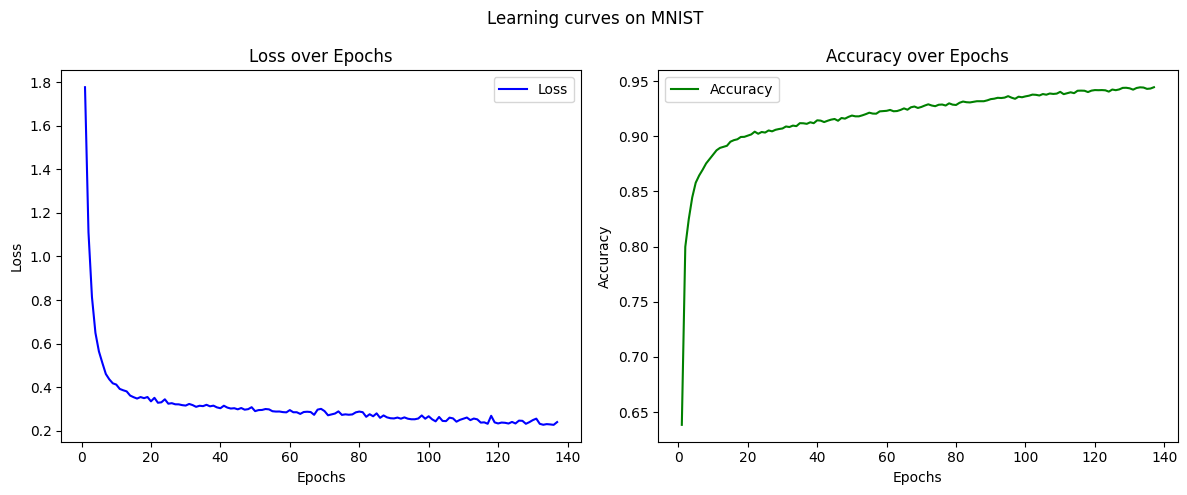

In [ ]:
import math
import gc

gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_mnist,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_mnist.clients) * C),
    problem="mnist"
)

# save data
save_data(pool_mnist, losses, accuracies, elapsed, "dynhybrid_400_mnist")

plot_loss_accuracy(losses, accuracies, title="Learning curves on MNIST")


Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180
Current T round: 180.0
Max T round: 180.0
Min T round: 180.0
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16433709409141026
Time upload: 0.32867418818282046
Time upload: 0.49301128227423063
Time upload: 0.6244809575473588
Time upload: 0.7230832140022049
Time upload: 0.788818051638769
Time upload: 0.80525176104791
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.000000000000185/32.02145659109234 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.13786172866821 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1000, test loss: 2.4217, round time: 162.29970049858093

Running round: 2 - Time elapsed: 162.299702167511 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0
Current T round: 184.9055141869709
Max T round: 184.9055141869709
Min T round: 180.0
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.800000000000153/29.837228305003986 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 150.95886063575745 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1000, test loss: 3.8659, round time: 184.1879632472992

Running round: 3 - Time elapsed: 346.4891550540924 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.9055141869709
Current T round: 182.1650784703827
Max T round: 184.9055141869709
Min T round: 180.0
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.00000000000023/35.06094883355143 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.0020034313202 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1393, test loss: 2.8501, round time: 170.54747438430786

Running round: 4 - Time elapsed: 517.0381209850311 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.1650784703827
Current T round: 178.43657006365544
Max T round: 184.9055141869709
Min T round: 178.43657006365544
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.60000000000022/34.632434986900584 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.73900628089905 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1295, test loss: 4.0476, round time: 173.81650757789612

Running round: 5 - Time elapsed: 690.856219291687 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.43657006365544
Current T round: 179.08002153719679
Max T round: 184.9055141869709
Min T round: 178.43657006365544
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.60000000000021/33.638644078605815 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.13400864601135 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1257, test loss: 3.4276, round time: 172.2429850101471

Running round: 6 - Time elapsed: 863.1007287502289 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.08002153719679
Current T round: 182.60957446890265
Max T round: 184.9055141869709
Min T round: 178.43657006365544
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16973307193843554
Time upload: 0.339466143876871
Time upload: 0.5091992158153065
Time upload: 0.6796325475713332
Time upload: 0.8511162690537459
Time upload: 1.0059768132511104
Time upload: 1.1611874873572703
Time upload: 1.2821014171669476
Time upload: 1.385691909873986
Time upload: 1.4896325324898196
Time upload: 1.5762497180030144
Time upload: 1.6

Distributing model...: 100%|█████████▉| 34.00000000000021/34.051028738481705 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.86685848236084 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2068, test loss: 2.4956, round time: 172.36519527435303

Running round: 7 - Time elapsed: 1035.4675991535187 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.60957446890265
Current T round: 182.1691951795988
Max T round: 184.9055141869709
Min T round: 178.43657006365544
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1820899108798486
Time upload: 0.3641798217596971
Time upload: 0.5462697326395457
Time upload: 0.6919416613434249
Time upload: 0.8011956078713344
Time upload: 0.8558225811352891
Time upload: 0.8922405633112589
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.50000000000022/34.57452112673047 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.60144281387329 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1915, test loss: 2.8346, round time: 162.93177247047424

Running round: 8 - Time elapsed: 1198.4008202552795 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.1691951795988
Current T round: 179.62169495179137
Max T round: 184.9055141869709
Min T round: 178.43657006365544
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19262672502027814
Time upload: 0.3852534500405561
Time upload: 0.5778801750608342
Time upload: 0.731981555077057
Time upload: 0.8282949175871962
Time upload: 0.8860829350932797
Time upload: 0.9246082800973354
Time upload: 0.9438709525993633
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.923796581378735 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 155.47729802131653 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2474, test loss: 2.4668, round time: 190.26400995254517

Running round: 9 - Time elapsed: 1388.666314125061 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.62169495179137
Current T round: 184.55658637200565
Max T round: 184.9055141869709
Min T round: 178.43657006365544
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.425174241547055 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 127.15128374099731 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1550, test loss: 3.3789, round time: 164.04322004318237

Running round: 10 - Time elapsed: 1552.7110760211945 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.55658637200565
Current T round: 178.7589465076817
Max T round: 184.9055141869709
Min T round: 178.43657006365544
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.20983066092127797
Time upload: 0.39867825575042815
Time upload: 0.5665427844874503
Time upload: 0.7344073132244723
Time upload: 0.8603057097772387
Time upload: 0.9442379741457497
Time upload: 1.007187172422133
Time upload: 1.0281702385142608
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.36019035180386 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.86412858963013 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2076, test loss: 3.0108, round time: 164.1882405281067

Running round: 11 - Time elapsed: 1716.9010927677155 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.7589465076817
Current T round: 186.8792542888696
Max T round: 186.8792542888696
Min T round: 178.43657006365544
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.500000000000163/30.50064231351444 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.87492775917053 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2230, test loss: 3.0046, round time: 181.79501247406006

Running round: 12 - Time elapsed: 1898.6975421905518 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 186.8792542888696
Current T round: 178.0315708809657
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19640977643126908
Time upload: 0.39281955286253806
Time upload: 0.589229329293807
Time upload: 0.7463571504388221
Time upload: 0.8642030162975834
Time upload: 0.9231259492269641
Time upload: 0.9624079045132179
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.70000000000021/33.73466539884076 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 136.36255359649658 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2907, test loss: 2.4465, round time: 173.88690614700317

Running round: 13 - Time elapsed: 2072.585876226425 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.0315708809657
Current T round: 178.16129578473573
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18667669683925794
Time upload: 0.37335339367851594
Time upload: 0.541362420833848
Time upload: 0.6720361086213282
Time upload: 0.765374457040957
Time upload: 0.8587128054605857
Time upload: 0.8960481448284372
Time upload: 0.914715814512363
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.80000000000021/33.884567505420435 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 152.3523337841034 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2541, test loss: 2.6826, round time: 189.99021649360657

Running round: 14 - Time elapsed: 2262.577513217926 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.16129578473573
Current T round: 180.56790643903292
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1698338674293138
Time upload: 0.33966773485862756
Time upload: 0.5095016022879413
Time upload: 0.6453686962313927
Time upload: 0.7472690166889813
Time upload: 0.7982191769177756
Time upload: 0.8321859504036384
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.00000000000021/34.08151874514004 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 129.33199501037598 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2092, test loss: 2.9761, round time: 167.17426562309265

Running round: 15 - Time elapsed: 2429.753383398056 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.56790643903292
Current T round: 181.61692664146122
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17706516678639309
Time upload: 0.3364238168941469
Time upload: 0.47807595032326144
Time upload: 0.619728083752376
Time upload: 0.7259671838242119
Time upload: 0.7967932505387691
Time upload: 0.8499128005746871
Time upload: 0.8676193172533264
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.100000000000172/31.18140298741922 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 156.14426040649414 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2335, test loss: 3.0769, round time: 191.17153596878052

Running round: 16 - Time elapsed: 2620.9265892505646 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.61692664146122
Current T round: 183.92587354916694
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.166659224661154
Time upload: 0.3333184493223081
Time upload: 0.4999776739834623
Time upload: 0.6674698136227276
Time upload: 0.8366277832182152
Time upload: 1.009117412726147
Time upload: 1.1832728721903003
Time upload: 1.3407624091883381
Time upload: 1.463254271297923
Time upload: 1.5507484585190552
Time upload: 1.6382426457401873
Time upload: 1.6

Distributing model...: 100%|█████████▉| 37.20000000000026/37.2783048642353 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.73855257034302 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2314, test loss: 3.1230, round time: 172.5602810382843

Running round: 17 - Time elapsed: 2793.4886009693146 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.92587354916694
Current T round: 178.74508420271601
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.46708134285137 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 120.81547379493713 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2478, test loss: 3.0546, round time: 158.637681722641

Running round: 18 - Time elapsed: 2952.1279516220093 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.74508420271601
Current T round: 182.2978524879433
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.60000000000018/31.613006216429305 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 148.12569952011108 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2838, test loss: 2.7997, round time: 183.1158366203308

Running round: 19 - Time elapsed: 3135.245191335678 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.2978524879433
Current T round: 181.50248125761004
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15932399846433495
Time upload: 0.31864799692867
Time upload: 0.4779719953930052
Time upload: 0.605431194164473
Time upload: 0.7010255932430738
Time upload: 0.7488227927823742
Time upload: 0.7806875924752411
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.700000000000166/30.792356817150765 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 150.39592170715332 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3162, test loss: 2.7516, round time: 184.90626406669617

Running round: 20 - Time elapsed: 3320.1529479026794 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.50248125761004
Current T round: 180.0275980868535
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.100000000000186/32.11503624360576 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 131.44428825378418 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3108, test loss: 2.5196, round time: 166.94092345237732

Running round: 21 - Time elapsed: 3487.0954308509827 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0275980868535
Current T round: 182.22159028997962
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.18221785884113087
Time upload: 0.36806304029698367
Time upload: 0.5539082217528364
Time upload: 0.7397534032086888
Time upload: 0.9364805525087068
Time upload: 1.1222405611540553
Time upload: 1.3080005697994037
Time upload: 1.4791661151753606
Time upload: 1.653958983166039
Time upload: 1.7632045256602131
Time upload: 1.8506009596555524
Time upload: 

Distributing model...: 100%|█████████▉| 32.20000000000019/32.25367716826707 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 149.00392365455627 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2720, test loss: 2.5863, round time: 185.8198561668396

Running round: 22 - Time elapsed: 3672.9171376228333 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.22159028997962
Current T round: 179.94304942577938
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.800000000000182/31.873004070515815 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.50423526763916 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2931, test loss: 2.6496, round time: 181.7328131198883

Running round: 23 - Time elapsed: 3854.651375055313 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.94304942577938
Current T round: 181.77664773427014
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1655814723743375
Time upload: 0.3146047975112414
Time upload: 0.4470699754107115
Time upload: 0.5795351533101816
Time upload: 0.6788840367347841
Time upload: 0.7451166256845192
Time upload: 0.7947910673968205
Time upload: 0.8113492146342542
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.900000000000183/31.924791723360446 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 128.23229002952576 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3242, test loss: 2.5444, round time: 164.03907227516174

Running round: 24 - Time elapsed: 4018.6920688152313 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.77664773427014
Current T round: 183.15698261516144
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 5
Time upload: 0
Time upload: 0.16876092871365847
Time upload: 0.33752185742731683
Time upload: 0.5062827861409751
Time upload: 0.67939715306499
Time upload: 0.8568649581993617
Time upload: 1.0416100056802409
Time upload: 1.2285317722662976
Time upload: 1.4183773429885052
Time upload: 1.6113764141037983
Time upload: 1.805122570250064
Time upload: 2.0003628964582747
Time upload: 2

Distributing model...: 100%|█████████▉| 32.9000000000002/32.94209231140063 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 129.06090807914734 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3518, test loss: 2.1634, round time: 167.65866446495056

Running round: 25 - Time elapsed: 4186.3521111011505 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.15698261516144
Current T round: 184.08301244325312
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.800000000000168/30.876754273302605 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.41414332389832 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2794, test loss: 3.3389, round time: 159.64384126663208

Running round: 26 - Time elapsed: 4345.9975435733795 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.08301244325312
Current T round: 184.14525180456445
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1628757001825773
Time upload: 0.3257514003651547
Time upload: 0.4886271005477323
Time upload: 0.6189276606937943
Time upload: 0.7166530808033409
Time upload: 0.7655157908581142
Time upload: 0.7980909308946297
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.30000000000023/35.38948101344659 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.12921500205994 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2978, test loss: 2.6992, round time: 165.35804319381714

Running round: 27 - Time elapsed: 4511.356974840164 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.14525180456445
Current T round: 183.41361212261847
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.100000000000215/34.13421322924265 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 133.38748836517334 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2952, test loss: 2.6016, round time: 170.9161012172699

Running round: 28 - Time elapsed: 4682.274799108505 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.41361212261847
Current T round: 183.42303665075934
Max T round: 186.8792542888696
Min T round: 178.0315708809657
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18514457603710457
Time upload: 0.3517746944704987
Time upload: 0.49989035530018233
Time upload: 0.6480060161298664
Time upload: 0.7590927617521295
Time upload: 0.8331505921669715
Time upload: 0.888693964978103
Time upload: 0.9072084225818136
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.46026806451895 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 133.12088179588318 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3339, test loss: 2.3732, round time: 170.42587041854858

Running round: 29 - Time elapsed: 4852.70227766037 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.42303665075934
Current T round: 177.39508854255152
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17872463991756413
Time upload: 0.35890949362231755
Time upload: 0.5405545611142604
Time upload: 0.7251200561805822
Time upload: 0.909685551246904
Time upload: 1.0778387961086586
Time upload: 1.2459920409704133
Time upload: 1.378400357848655
Time upload: 1.4736035329561945
Time upload: 1.5702669218509233
Time upload: 1.6669303107456521
Time upload: 1

Distributing model...: 100%|█████████▉| 33.3000000000002/33.37457729436847 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 127.73814272880554 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3547, test loss: 2.2610, round time: 165.77193808555603

Running round: 30 - Time elapsed: 5018.475619316101 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.39508854255152
Current T round: 180.1934908343769
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16845515471953978
Time upload: 0.3385502623718075
Time upload: 0.5086453700240752
Time upload: 0.6820203835417993
Time upload: 0.8553953970595234
Time upload: 1.0353302223081595
Time upload: 1.2169050004895237
Time upload: 1.3430233734568418
Time upload: 1.4522962309522058
Time upload: 1.526238104570934
Time upload: 1.58169450978498
Time upload: 1.6

Distributing model...: 100%|█████████▉| 32.700000000000195/32.7378923008508 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.27588391304016 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3648, test loss: 2.1341, round time: 161.614972114563

Running round: 31 - Time elapsed: 5180.0922935009 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.1934908343769
Current T round: 182.03815291118656
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1630505611947151
Time upload: 0.3275015041369958
Time upload: 0.49195244707927666
Time upload: 0.6592041535166885
Time upload: 0.8087504220870633
Time upload: 0.9461927797806631
Time upload: 1.0850355192218288
Time upload: 1.2061728207959577
Time upload: 1.3287105041176521
Time upload: 1.434943131319875
Time upload: 1.5234703206550608
Time upload: 1.611

Distributing model...: 100%|█████████▉| 30.20000000000016/30.259096664875763 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.54360222816467 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2664, test loss: 3.0737, round time: 181.3810088634491

Running round: 32 - Time elapsed: 5361.474842071533 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.03815291118656
Current T round: 180.8528097426132
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.16694231475647772
Time upload: 0.33508206832176385
Time upload: 0.5044192606958585
Time upload: 0.673756453069953
Time upload: 0.8454885230616646
Time upload: 1.0196154706709932
Time upload: 1.1953156371007345
Time upload: 1.373598571153895
Time upload: 1.5518815052070554
Time upload: 1.7317376580806285
Time upload: 1.8937021406697454
Time upload: 2.

Distributing model...: 100%|█████████▉| 29.300000000000146/29.32364949805402 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.02337336540222 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2890, test loss: 3.0745, round time: 180.48922657966614

Running round: 33 - Time elapsed: 5541.965676546097 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.8528097426132
Current T round: 181.86529282184728
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1558231463234651
Time upload: 0.3116462926469302
Time upload: 0.46746943897039517
Time upload: 0.6240083731070462
Time upload: 0.7812630950568832
Time upload: 0.9395914987264993
Time upload: 1.082337587763769
Time upload: 1.2254415707076318
Time upload: 1.352963239019148
Time upload: 1.4326642817138455
Time upload: 1.480484907330664
Time upload: 1.5

Distributing model...: 100%|█████████▉| 34.40000000000022/34.44414556145801 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.06682109832764 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4000, test loss: 2.0264, round time: 162.0646800994873

Running round: 34 - Time elapsed: 5704.031823396683 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.86529282184728
Current T round: 180.0783603166998
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1859486753166728
Time upload: 0.3718973506333456
Time upload: 0.5578460259500184
Time upload: 0.7066049662033567
Time upload: 0.8181741713933603
Time upload: 0.8739587739883622
Time upload: 0.9111485090516968
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.800000000000153/29.815223985200944 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 142.52362775802612 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3600, test loss: 2.2911, round time: 176.23910856246948

Running round: 35 - Time elapsed: 5880.272347211838 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0783603166998
Current T round: 178.4399652586446
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.57782776316492 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.8310136795044 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3046, test loss: 3.0410, round time: 160.77341389656067

Running round: 36 - Time elapsed: 6041.047313690186 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.4399652586446
Current T round: 185.94911968054808
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17846004270421498
Time upload: 0.3390740811380084
Time upload: 0.4818421153013803
Time upload: 0.6246101494647522
Time upload: 0.7316861750872812
Time upload: 0.8030701921689671
Time upload: 0.8566082049802316
Time upload: 0.8744542092506531
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.700000000000166/30.727974835680605 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 157.27001643180847 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3755, test loss: 2.3476, round time: 191.88758277893066

Running round: 37 - Time elapsed: 6232.936573505402 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.94911968054808
Current T round: 182.4286138521694
Max T round: 186.8792542888696
Min T round: 177.39508854255152
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19197142266389003
Time upload: 0.36474570306139115
Time upload: 0.5183228411925033
Time upload: 0.6335056947908374
Time upload: 0.7486885483891715
Time upload: 0.8254771174547276
Time upload: 0.9022656865202837
Time upload: 0.9406599710530618
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.00000000000021/34.052989098399486 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.66872024536133 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3678, test loss: 2.5041, round time: 170.56446313858032

Running round: 38 - Time elapsed: 6403.502443790436 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.4286138521694
Current T round: 175.98659143043855
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18009596673958098
Time upload: 0.3601919334791618
Time upload: 0.5402879002187425
Time upload: 0.6843646736104071
Time upload: 0.7924222536541555
Time upload: 0.8644606403499878
Time upload: 0.8824702370239459
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.10000000000023/35.148647166128384 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.85228157043457 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3644, test loss: 2.5792, round time: 171.88361239433289

Running round: 39 - Time elapsed: 6575.388014554977 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.98659143043855
Current T round: 184.86967765756623
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17188993649608955
Time upload: 0.34672953770064074
Time upload: 0.5245188036136533
Time upload: 0.7023080695266656
Time upload: 0.8658580064985305
Time upload: 1.0353072728873187
Time upload: 1.1875675456264982
Time upload: 1.3457271477826007
Time upload: 1.5038867499387032
Time upload: 1.6448573584451966
Time upload: 1.7455506502355491
Time upload

Distributing model...: 100%|█████████▉| 31.800000000000182/31.808738896056525 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.99813270568848 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3488, test loss: 2.7446, round time: 183.2420015335083

Running round: 40 - Time elapsed: 6758.63148021698 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.86967765756623
Current T round: 182.29170979087812
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.700000000000195/32.754626119472874 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 167.3617537021637 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3237, test loss: 2.7669, round time: 203.58941197395325

Running round: 41 - Time elapsed: 6962.223200559616 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.29170979087812
Current T round: 180.1248941746782
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.20099750769129396
Time upload: 0.3818952646134585
Time upload: 0.562793021535623
Time upload: 0.7436907784577876
Time upload: 0.864289283072564
Time upload: 0.9245885353799522
Time upload: 0.9848877876873404
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.8085211901662 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.9066436290741 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3610, test loss: 2.5134, round time: 161.48054122924805

Running round: 42 - Time elapsed: 7123.707473993301 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.1248941746782
Current T round: 185.9048424970353
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17783847244847154
Time upload: 0.3556769448969431
Time upload: 0.5373458549623765
Time upload: 0.7266756402617335
Time upload: 0.923666300795014
Time upload: 1.1206569613282946
Time upload: 1.307524649850652
Time upload: 1.4549942062663535
Time upload: 1.5808494778202458
Time upload: 1.688920902129291
Time upload: 1.7537637567147182
Time upload: 1.796

Distributing model...: 100%|█████████▉| 35.00000000000023/35.04267824895058 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.06476545333862 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4233, test loss: 1.8472, round time: 167.70432877540588

Running round: 43 - Time elapsed: 7291.413299560547 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.9048424970353
Current T round: 182.24134129669642
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15707289992593246
Time upload: 0.2984385098592717
Time upload: 0.4240968298000176
Time upload: 0.5497551497407638
Time upload: 0.6439988896963236
Time upload: 0.7068280496666968
Time upload: 0.7539499196444767
Time upload: 0.76965720963707
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.700000000000166/30.7734323860128 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.59205794334412 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4347, test loss: 1.9141, round time: 156.04424238204956

Running round: 44 - Time elapsed: 7447.4595079422 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.24134129669642
Current T round: 182.43275912242441
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.18069720994313132
Time upload: 0.3633074244280509
Time upload: 0.5478306434547586
Time upload: 0.7323538624814665
Time upload: 0.9207030905917508
Time upload: 1.1128783277856114
Time upload: 1.2869838439851586
Time upload: 1.4449326437321812
Time upload: 1.5828987179431024
Time upload: 1.662829620087508
Time upload: 1.7427605222319134
Time upload: 1.

Distributing model...: 100%|█████████▉| 35.10000000000023/35.12820365097157 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.37120246887207 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3568, test loss: 2.7410, round time: 170.05648159980774

Running round: 45 - Time elapsed: 7617.517679691315 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.43275912242441
Current T round: 183.53296849070298
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19891455406550046
Time upload: 0.3779376527244507
Time upload: 0.5370692959768508
Time upload: 0.696200939229251
Time upload: 0.8155496716685511
Time upload: 0.8951154932947512
Time upload: 0.9547898595144012
Time upload: 0.9746813149209512
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.26500026687234 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 145.98720240592957 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4199, test loss: 2.3018, round time: 182.9832100868225

Running round: 46 - Time elapsed: 7800.502460479736 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.53296849070298
Current T round: 185.6113842988397
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.351134172227713 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 154.6691439151764 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4262, test loss: 2.0903, round time: 189.32828640937805

Running round: 47 - Time elapsed: 7989.83234500885 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.6113842988397
Current T round: 186.4659831774428
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.2190997039072148
Time upload: 0.41628943742370794
Time upload: 0.6134791709402013
Time upload: 0.7668489636752519
Time upload: 0.9202187564103025
Time upload: 0.985948667582467
Time upload: 1.02976860836391
Time upload: 1.073588549145353
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 34.200000000000216/34.24325714828774 [00:34<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 156.19928002357483 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4066, test loss: 2.2976, round time: 194.26170945167542

Running round: 48 - Time elapsed: 8184.095545291901 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 186.4659831774428
Current T round: 177.89643527777395
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16587723764929052
Time upload: 0.3333872580195028
Time upload: 0.5008972783897151
Time upload: 0.6684072987599269
Time upload: 0.8408156672929038
Time upload: 1.018122383988646
Time upload: 1.1772085941985373
Time upload: 1.3213398633644213
Time upload: 1.4488834087653764
Time upload: 1.53998594119463
Time upload: 1.6128679671380328
Time upload: 1.6

Distributing model...: 100%|█████████▉| 32.30000000000019/32.37820962691927 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.57235789299011 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4310, test loss: 2.0352, round time: 159.2975151538849

Running round: 49 - Time elapsed: 8343.394644498825 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.89643527777395
Current T round: 181.2606605298215
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17354728097219618
Time upload: 0.34757852343145285
Time upload: 0.5220937273777702
Time upload: 0.6966089313240875
Time upload: 0.8720920582445262
Time upload: 1.0307044185548058
Time upload: 1.1898007403521458
Time upload: 1.3320262955393265
Time upload: 1.4742518507265072
Time upload: 1.5991226778164682
Time upload: 1.688316125737869
Time upload: 1

Distributing model...: 100%|█████████▉| 36.00000000000024/36.06221832071184 [00:36<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.64028978347778 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3813, test loss: 2.5319, round time: 169.2734031677246

Running round: 50 - Time elapsed: 8512.669460773468 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.2606605298215
Current T round: 178.3294909828341
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.70000000000022/34.738835387849356 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.5558454990387 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3376, test loss: 3.2370, round time: 169.65416479110718

Running round: 51 - Time elapsed: 8682.325235366821 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.3294909828341
Current T round: 180.10887682940793
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.0000000000002/33.041103277199774 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 121.94600820541382 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3402, test loss: 2.7968, round time: 158.3344602584839

Running round: 52 - Time elapsed: 8840.66132760048 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.10887682940793
Current T round: 177.2096191607691
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1583659952066588
Time upload: 0.3186700550435283
Time upload: 0.4809121795106085
Time upload: 0.6431543039776884
Time upload: 0.8092725577051894
Time upload: 0.9792669406931116
Time upload: 1.1156500600094919
Time upload: 1.2381346444354167
Time upload: 1.3606192288613415
Time upload: 1.4494925496157238
Time upload: 1.5205912062192297
Time upload: 1.5

Distributing model...: 100%|█████████▉| 30.800000000000168/30.81717921974837 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.57939529418945 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3383, test loss: 2.8045, round time: 156.96264958381653

Running round: 53 - Time elapsed: 8997.62549495697 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.2096191607691
Current T round: 180.19351080364265
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18417844870729452
Time upload: 0.36835689741458905
Time upload: 0.5525353461218837
Time upload: 0.6998781050877197
Time upload: 0.8103851743120968
Time upload: 0.8656387089242853
Time upload: 0.9024743986657443
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.100000000000158/30.121401046594055 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 119.26215434074402 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3588, test loss: 3.0018, round time: 153.0281126499176

Running round: 54 - Time elapsed: 9150.65499329567 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.19351080364265
Current T round: 185.4700326324385
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18958637782511012
Time upload: 0.37917275565022013
Time upload: 0.5687591334753304
Time upload: 0.7393868735179299
Time upload: 0.8720973379955073
Time upload: 0.9289732513430404
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.10000000000026/37.11475475956968 [00:37<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.44721150398254 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4448, test loss: 2.0615, round time: 174.46020770072937

Running round: 55 - Time elapsed: 9325.116935491562 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.4700326324385
Current T round: 180.67366775653628
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17251719645762775
Time upload: 0.32778267326949273
Time upload: 0.46579643043559493
Time upload: 0.6038101876016971
Time upload: 0.7073205054762738
Time upload: 0.7763273840593249
Time upload: 0.8280825429966132
Time upload: 0.845334262642376
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.400000000000176/31.444107582115187 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.74946331977844 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4114, test loss: 2.5573, round time: 158.98289132118225

Running round: 56 - Time elapsed: 9484.101200819016 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.67366775653628
Current T round: 183.71419728983875
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19532587500623275
Time upload: 0.3711191625118421
Time upload: 0.5273798625168282
Time upload: 0.6836405625218143
Time upload: 0.8008360875255538
Time upload: 0.8789664375280468
Time upload: 0.9375642000299166
Time upload: 0.9570967875305398
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.451304091058155 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.5501561164856 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4160, test loss: 2.6004, round time: 165.8339822292328

Running round: 57 - Time elapsed: 9649.936680316925 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.71419728983875
Current T round: 184.48858148587726
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.10000000000024/36.18069812982436 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 148.01901960372925 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3407, test loss: 3.3584, round time: 187.47716236114502

Running round: 58 - Time elapsed: 9837.415335178375 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.48858148587726
Current T round: 182.25481454944955
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.800000000000182/31.866605095963067 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 153.93552923202515 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3955, test loss: 2.5731, round time: 189.04118490219116

Running round: 59 - Time elapsed: 10026.457929611206 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.25481454944955
Current T round: 183.4407283363792
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.39945515491046 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 170.67446947097778 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4192, test loss: 2.6518, round time: 205.37332701683044

Running round: 60 - Time elapsed: 10231.832878828049 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.4407283363792
Current T round: 180.12776517545964
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.800000000000225/34.89251120305475 [00:35<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 132.06131386756897 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4335, test loss: 2.4913, round time: 170.19971823692322

Running round: 61 - Time elapsed: 10402.034160375595 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.12776517545964
Current T round: 181.90918924749897
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.40000000000023/35.49085612268174 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.03983855247498 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3755, test loss: 2.8679, round time: 168.78373956680298

Running round: 62 - Time elapsed: 10570.819591999054 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.90918924749897
Current T round: 178.51631312302217
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16491178064053258
Time upload: 0.3319346490630326
Time upload: 0.5010686052675001
Time upload: 0.670202561471968
Time upload: 0.8249564273943502
Time upload: 0.9839324688806672
Time upload: 1.126417332302931
Time upload: 1.2731243712891296
Time upload: 1.4198314102753282
Time upload: 1.5500472711974735
Time upload: 1.6430586004275773
Time upload: 

Distributing model...: 100%|█████████▉| 32.20000000000019/32.21712328929466 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.94859099388123 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3523, test loss: 2.7945, round time: 159.52843022346497

Running round: 63 - Time elapsed: 10730.349619865417 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.51631312302217
Current T round: 183.823645363151
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 4
Time upload: 0
Time upload: 0.1737601731113204
Time upload: 0.3475203462226407
Time upload: 0.521280519333961
Time upload: 0.6958511152624421
Time upload: 0.8712321340080841
Time upload: 1.0474235755708872
Time upload: 1.2266809867518662
Time upload: 1.4059383979328453
Time upload: 1.5893016913072726
Time upload: 1.7748255904307586
Time upload: 1.9640501603391125
Time upload: 2.

Distributing model...: 100%|█████████▉| 30.500000000000163/30.561661390582877 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.4454927444458 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4079, test loss: 2.6588, round time: 183.4896981716156

Running round: 64 - Time elapsed: 10913.840844869614 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.823645363151
Current T round: 177.3205883450082
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17074651956143524
Time upload: 0.3414930391228706
Time upload: 0.512239558684306
Time upload: 0.665911426289598
Time upload: 0.7854339899826028
Time upload: 0.8366579458510335
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.100000000000158/30.193551152628817 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 151.89558243751526 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4629, test loss: 1.9129, round time: 185.72975659370422

Running round: 65 - Time elapsed: 11099.572026252747 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.3205883450082
Current T round: 182.24035107797505
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1547624406058367
Time upload: 0.3126697053533625
Time upload: 0.47057697010088834
Time upload: 0.6347738831317922
Time upload: 0.7989707961626961
Time upload: 0.9757470057603561
Time upload: 1.1556680394997052
Time upload: 1.2983469368345086
Time upload: 1.388307453704183
Time upload: 1.4441706583110012
Time upload: 1.5000338629178194
Time upload: 

Distributing model...: 100%|█████████▉| 33.2000000000002/33.27213664611758 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 123.87564373016357 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3898, test loss: 2.3036, round time: 161.72239136695862

Running round: 66 - Time elapsed: 11261.29581618309 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.24035107797505
Current T round: 179.06148052903578
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.30000000000022/34.34389463891897 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.030779838562 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3829, test loss: 2.4955, round time: 165.69877791404724

Running round: 67 - Time elapsed: 11426.996166229248 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.06148052903578
Current T round: 178.7691052844924
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 28.90000000000014/28.9792180902681 [00:29<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.62386798858643 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4038, test loss: 2.1405, round time: 178.82512855529785

Running round: 68 - Time elapsed: 11605.822818040848 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.7691052844924
Current T round: 185.62148090254993
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17456602298532212
Time upload: 0.3491320459706441
Time upload: 0.523698068955966
Time upload: 0.6987876744841015
Time upload: 0.8746626538264574
Time upload: 1.051061215711627
Time upload: 1.2277215688682035
Time upload: 1.3869253197262477
Time upload: 1.5106922834444139
Time upload: 1.6170026448640478
Time upload: 1.6524394320039257
Time upload: 1

Distributing model...: 100%|█████████▉| 35.600000000000236/35.65638067667474 [00:36<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.64107847213745 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4225, test loss: 2.4548, round time: 161.6771640777588

Running round: 69 - Time elapsed: 11767.501585006714 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.62148090254993
Current T round: 185.9239395943862
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.19224878133238532
Time upload: 0.38449756266477064
Time upload: 0.5767463439971559
Time upload: 0.7699085065816323
Time upload: 0.9639840504182008
Time upload: 1.158972975506861
Time upload: 1.3356504037143746
Time upload: 1.5123278319218882
Time upload: 1.6697803819961634
Time upload: 1.7681882257925854
Time upload: 1.8272329320704386
Time upload: 

Distributing model...: 100%|█████████▉| 33.70000000000021/33.740028075390825 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.75945568084717 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3560, test loss: 2.9376, round time: 170.03456449508667

Running round: 70 - Time elapsed: 11937.537794828415 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.9239395943862
Current T round: 183.45138980214662
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17396809667217394
Time upload: 0.3479947375235509
Time upload: 0.5220213783749278
Time upload: 0.6961651075847101
Time upload: 0.8703088367944923
Time upload: 1.0446867427210866
Time upload: 1.1842124851340439
Time upload: 1.323738227547001
Time upload: 1.4458671602927409
Time upload: 1.5331439295248428
Time upload: 1.585509991064104
Time upload: 1

Distributing model...: 100%|█████████▉| 35.20000000000023/35.241967606913555 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.38355374336243 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4394, test loss: 2.0642, round time: 170.2019498348236

Running round: 71 - Time elapsed: 12107.741149902344 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.45138980214662
Current T round: 179.61507676075595
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.20000000000016/30.261225897139244 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 144.6708118915558 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4626, test loss: 1.9672, round time: 178.26301455497742

Running round: 72 - Time elapsed: 12286.005698680878 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.61507676075595
Current T round: 182.79681253500235
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.18051370199560335
Time upload: 0.3610274039912066
Time upload: 0.5421650636806246
Time upload: 0.7245506387576719
Time upload: 0.9081841292223483
Time upload: 1.0918176196870246
Time upload: 1.2586476553397696
Time upload: 1.3887509928995794
Time upload: 1.5001790025660142
Time upload: 1.5935556420328887
Time upload: 1.6495816257130134
Time upload:

Distributing model...: 100%|█████████▉| 34.70000000000022/34.79700579436989 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.74235725402832 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4587, test loss: 2.1932, round time: 175.05406665802002

Running round: 73 - Time elapsed: 12461.061568498611 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.79681253500235
Current T round: 180.51839424405367
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1703619783354261
Time upload: 0.3441272938109998
Time upload: 0.5178926092865735
Time upload: 0.6984645990424427
Time upload: 0.8790365887983119
Time upload: 1.0732219271147723
Time upload: 1.25037106759769
Time upload: 1.4070806731069174
Time upload: 1.5467540807826021
Time upload: 1.6693912906247441
Time upload: 1.7715889654931958
Time upload: 1

Distributing model...: 100%|█████████▉| 37.30000000000026/37.36187717897617 [00:37<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 129.04461216926575 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4442, test loss: 2.2609, round time: 170.77609586715698

Running round: 74 - Time elapsed: 12631.839176177979 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.51839424405367
Current T round: 181.59546677257734
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.800000000000182/31.853117139402798 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 153.7942397594452 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4142, test loss: 2.5616, round time: 188.97289657592773

Running round: 75 - Time elapsed: 12820.813490390778 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.59546677257734
Current T round: 183.60091516586525
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.500000000000163/30.52595347153201 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 148.00558996200562 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4186, test loss: 2.4450, round time: 181.79508996009827

Running round: 76 - Time elapsed: 13002.609989643097 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.60091516586525
Current T round: 181.44632988430217
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16383827580936985
Time upload: 0.3276765516187397
Time upload: 0.49151482742810954
Time upload: 0.6225854480756058
Time upload: 0.704504585980291
Time upload: 0.7536560687231021
Time upload: 0.7864237238849762
Time upload: 0.8028075514659132
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.900000000000226/34.92321134718944 [00:35<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 132.17183351516724 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4017, test loss: 2.8643, round time: 170.8644082546234

Running round: 77 - Time elapsed: 13173.47600197792 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.44632988430217
Current T round: 180.65832800411278
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1498833896017779
Time upload: 0.2997667792035559
Time upload: 0.44965016880533404
Time upload: 0.6082536386966884
Time upload: 0.7755771888776188
Time upload: 0.9322724402431596
Time upload: 1.082699432938099
Time upload: 1.2137780465280728
Time upload: 1.3492167002628348
Time upload: 1.4653069748926308
Time upload: 1.5427004913124949
Time upload: 1

Distributing model...: 100%|█████████▉| 31.70000000000018/31.74368943159188 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.83711862564087 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3798, test loss: 2.6621, round time: 160.20083022117615

Running round: 78 - Time elapsed: 13333.678368806839 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.65832800411278
Current T round: 181.81235560648653
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.15806252161563783
Time upload: 0.31612504323127566
Time upload: 0.47666944967766856
Time upload: 0.6421776257855716
Time upload: 0.8126495715549846
Time upload: 0.9648333803320788
Time upload: 1.1244628436014386
Time upload: 1.2682860547092347
Time upload: 1.412109265817031
Time upload: 1.5401262247632632
Time upload: 1.6315669097248577
Selected d

Distributing model...: 100%|█████████▉| 36.300000000000246/36.30641914881547 [00:36<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.74321293830872 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4621, test loss: 2.0931, round time: 186.41809391975403

Running round: 79 - Time elapsed: 13520.09799695015 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.81235560648653
Current T round: 181.63737196150126
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 28.80000000000014/28.8632415560698 [00:29<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 142.78864097595215 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4390, test loss: 2.2135, round time: 174.9067084789276

Running round: 80 - Time elapsed: 13695.006245613098 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.63737196150126
Current T round: 184.18469500616564
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1707683406374679
Time upload: 0.34153668127493575
Time upload: 0.5123050219124035
Time upload: 0.6489196944223781
Time upload: 0.751380698804859
Time upload: 0.8196880350598463
Time upload: 0.8367648691235932
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.700000000000195/32.71032181123544 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 152.57385969161987 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4461, test loss: 2.4051, round time: 189.09425950050354

Running round: 81 - Time elapsed: 13884.10195851326 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.18469500616564
Current T round: 180.72207660411556
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18049513900042827
Time upload: 0.34294076410081376
Time upload: 0.48733687530115644
Time upload: 0.6317329865014991
Time upload: 0.7400300699017561
Time upload: 0.8122281255019275
Time upload: 0.866376667202056
Time upload: 0.8844261811020988
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.0000000000002/33.08254722016755 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 127.616694688797 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4469, test loss: 2.3821, round time: 164.41571950912476

Running round: 82 - Time elapsed: 14048.519060611725 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.72207660411556
Current T round: 181.6991211827141
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.2112514243670467
Time upload: 0.4013777062973886
Time upload: 0.570378845791026
Time upload: 0.6971297004112543
Time upload: 0.8238805550314826
Time upload: 0.9083811247783015
Time upload: 0.9928816945251203
Time upload: 1.0351319793985296
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.900000000000254/36.93025038787574 [00:37<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 136.12972974777222 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4666, test loss: 2.0939, round time: 176.921213388443

Running round: 83 - Time elapsed: 14225.441893577576 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.6991211827141
Current T round: 181.34407140246134
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1485910018309271
Time upload: 0.2823229034787616
Time upload: 0.4011957049435034
Time upload: 0.5200685064082451
Time upload: 0.6092231075068011
Time upload: 0.6686595082391718
Time upload: 0.7132368087884497
Time upload: 0.7280959089715424
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.60000000000018/31.62196798788664 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 152.57949709892273 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4218, test loss: 2.4600, round time: 188.02044939994812

Running round: 84 - Time elapsed: 14413.463932991028 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.34407140246134
Current T round: 183.1553579799968
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.30000000000016/30.37143651405496 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 151.36833500862122 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4062, test loss: 2.7213, round time: 185.1233413219452

Running round: 85 - Time elapsed: 14598.588841438293 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.1553579799968
Current T round: 181.78238533698357
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16901582140175062
Time upload: 0.33803164280350123
Time upload: 0.4901458820650768
Time upload: 0.6253585391864769
Time upload: 0.7098664498873519
Time upload: 0.777472778448052
Time upload: 0.811275942728402
Time upload: 0.828177524868577
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.800000000000168/30.826466125376413 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 148.16942691802979 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4558, test loss: 2.5310, round time: 182.73160791397095

Running round: 86 - Time elapsed: 14781.321802139282 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.78238533698357
Current T round: 183.67994672170417
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1970869155018598
Time upload: 0.3941738310037194
Time upload: 0.571552054955393
Time upload: 0.7095128958066946
Time upload: 0.8080563535576244
Time upload: 0.9065998113085542
Time upload: 0.9460171944089261
Time upload: 0.965725885959112
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.800000000000225/34.83692652961182 [00:35<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 129.85792350769043 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4674, test loss: 2.3181, round time: 168.5288372039795

Running round: 87 - Time elapsed: 14949.852176904678 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.67994672170417
Current T round: 176.76563374894894
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16047726306680066
Time upload: 0.3209545261336012
Time upload: 0.4845974872972393
Time upload: 0.6545718446545524
Time upload: 0.811664173802023
Time upload: 0.9687565029494937
Time upload: 1.1161325019839594
Time upload: 1.2666741991152626
Time upload: 1.3787890474395306
Time upload: 1.494069593860636
Time upload: 1.6093501402817416
Time upload: 1

Distributing model...: 100%|█████████▉| 33.0000000000002/33.045345365009396 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 121.56818413734436 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4082, test loss: 3.2452, round time: 159.01992464065552

Running round: 88 - Time elapsed: 15108.873537063599 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.76563374894894
Current T round: 181.43729901584481
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17618092942734867
Time upload: 0.3347437659119625
Time upload: 0.49330660239657625
Time upload: 0.6166332529957204
Time upload: 0.7399599035948644
Time upload: 0.792814182423069
Time upload: 0.8280503683085387
Time upload: 0.8632865541940085
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.959930874751514 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.1370894908905 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4198, test loss: 2.8458, round time: 161.8517804145813

Running round: 89 - Time elapsed: 15270.726724863052 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.43729901584481
Current T round: 184.58661183573236
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.17745418801364402
Time upload: 0.3549979652641353
Time upload: 0.5326313317514739
Time upload: 0.7142383536283674
Time upload: 0.8958453755052609
Time upload: 1.0776315758558492
Time upload: 1.2377882912523652
Time upload: 1.401918662038436
Time upload: 1.5699330989772144
Time upload: 1.7418316020687004
Time upload: 1.9175245820760465
Time upload: 2

Distributing model...: 100%|█████████▉| 30.400000000000162/30.446362881702026 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 153.18773865699768 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4144, test loss: 2.4948, round time: 188.5841941833496

Running round: 90 - Time elapsed: 15459.312669992447 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.58661183573236
Current T round: 181.9361053372319
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.40000000000019/32.401261373967856 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.08219742774963 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3883, test loss: 2.9022, round time: 181.90901684761047

Running round: 91 - Time elapsed: 15641.223121404648 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.9361053372319
Current T round: 181.86461969340203
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16378329975525907
Time upload: 0.32756659951051814
Time upload: 0.49260040616709816
Time upload: 0.6601352266263203
Time upload: 0.8301710608881844
Time upload: 1.0002068951500485
Time upload: 1.1739942501158753
Time upload: 1.3137744382293295
Time upload: 1.4006681157122431
Time upload: 1.4535546263427839
Time upload: 1.5064411369733246
Time uploa

Distributing model...: 100%|█████████▉| 35.30000000000023/35.384561053518986 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.01891660690308 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4006, test loss: 2.8961, round time: 187.0993390083313

Running round: 92 - Time elapsed: 15828.32406258583 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.86461969340203
Current T round: 178.72851613195706
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.70000000000018/31.71156124272679 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 145.79531598091125 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4241, test loss: 2.6474, round time: 181.01041913032532

Running round: 93 - Time elapsed: 16009.336007595062 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.72851613195706
Current T round: 181.0817035862153
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15837148475777027
Time upload: 0.3009058210397636
Time upload: 0.42760300884598
Time upload: 0.5226258997006422
Time upload: 0.6176487905553042
Time upload: 0.6809973844584122
Time upload: 0.7443459783615202
Time upload: 0.7760202753130742
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.32080782292639 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.66954445838928 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3966, test loss: 3.1265, round time: 160.07828378677368

Running round: 94 - Time elapsed: 16169.415909290314 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.0817035862153
Current T round: 182.57084828126293
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16250280917103846
Time upload: 0.3250056183420769
Time upload: 0.4712581465960115
Time upload: 0.5850101130157387
Time upload: 0.6662615176012582
Time upload: 0.7475129221867777
Time upload: 0.7800134840209855
Time upload: 0.7962637649380894
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.80000000000025/36.81415744825373 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.8678593635559 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4871, test loss: 2.6020, round time: 176.73221492767334

Running round: 95 - Time elapsed: 16346.149499416351 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.57084828126293
Current T round: 182.66900667249394
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.2194939389940823
Time upload: 0.41703848408875654
Time upload: 0.5926336352840224
Time upload: 0.7682287864792879
Time upload: 0.8999251498757371
Time upload: 0.9877227254733699
Time upload: 1.0535709071715946
Time upload: 1.0755203010710028
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.20000000000026/37.248902506761034 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 138.150714635849 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4090, test loss: 3.5029, round time: 179.43134355545044

Running round: 96 - Time elapsed: 16525.582394599915 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.66900667249394
Current T round: 185.04868379132753
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16415443897686055
Time upload: 0.31189343405603515
Time upload: 0.45963242913520974
Time upload: 0.5745405364190119
Time upload: 0.689448643702814
Time upload: 0.738694975395872
Time upload: 0.771525863191244
Time upload: 0.8043567509866161
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.900000000000183/31.971803594573473 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 152.94172978401184 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4801, test loss: 2.2271, round time: 188.66896653175354

Running round: 97 - Time elapsed: 16714.252917289734 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.04868379132753
Current T round: 177.65108281470782
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1935149371398819
Time upload: 0.3870298742797639
Time upload: 0.5805448114196456
Time upload: 0.7547082548455389
Time upload: 0.890168710843456
Time upload: 0.9482231919854204
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.30000000000022/34.32883017690287 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.1780505180359 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4706, test loss: 2.6234, round time: 169.35406064987183

Running round: 98 - Time elapsed: 16883.608555555344 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.65108281470782
Current T round: 177.7990834289932
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.2025905858439304
Time upload: 0.4051811716878607
Time upload: 0.587512698947398
Time upload: 0.7293261090381492
Time upload: 0.8306214019601144
Time upload: 0.9319166948820795
Time upload: 0.9724348120508656
Time upload: 0.9926938706352586
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.200000000000145/29.247579989744597 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 143.40411686897278 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4931, test loss: 2.4757, round time: 176.50987219810486

Running round: 99 - Time elapsed: 17060.120100021362 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.7990834289932
Current T round: 179.49323914858232
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.58852386378213 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.1278760433197 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3977, test loss: 3.3766, round time: 159.0506854057312

Running round: 100 - Time elapsed: 17219.17223215103 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.49323914858232
Current T round: 182.05028031424337
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.700000000000152/29.70130213461161 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 140.76945328712463 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4564, test loss: 2.5231, round time: 173.86102032661438

Running round: 101 - Time elapsed: 17393.034719467163 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.05028031424337
Current T round: 185.1292760452229
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.15986032904414768
Time upload: 0.3197206580882953
Time upload: 0.4795809871324428
Time upload: 0.6402210746578629
Time upload: 0.8024206791458276
Time upload: 0.9677393175588811
Time upload: 1.1346174729344782
Time upload: 1.2855095954056603
Time upload: 1.4028701351054687
Time upload: 1.50346488341959
Time upload: 1.5369964661909639
Time upload: 

Distributing model...: 100%|█████████▉| 33.3000000000002/33.30205062628926 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 129.29361867904663 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4594, test loss: 2.9679, round time: 167.00672793388367

Running round: 102 - Time elapsed: 17560.043066740036 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.1292760452229
Current T round: 183.9035250524153
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.1702463811452547
Time upload: 0.341447002168629
Time upload: 0.5136018630701228
Time upload: 0.6857567239716166
Time upload: 0.8598200646293493
Time upload: 1.0365568167615251
Time upload: 1.2142478087718196
Time upload: 1.3946122122565574
Time upload: 1.5749766157412952
Time upload: 1.7383163811115077
Time upload: 1.8844422002072796
Time upload: 2

Distributing model...: 100%|█████████▉| 35.80000000000024/35.897542215954836 [00:36<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 153.01835584640503 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4620, test loss: 2.6452, round time: 193.8261058330536

Running round: 103 - Time elapsed: 17753.870629549026 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.9035250524153
Current T round: 179.67736504443405
Max T round: 186.8792542888696
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15946439842059315
Time upload: 0.3189287968411862
Time upload: 0.4783931952617791
Time upload: 0.6059647139982538
Time upload: 0.7016433530506099
Time upload: 0.7654291124188473
Time upload: 0.7813755522609066
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.49174135602017 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 130.71291303634644 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5034, test loss: 2.3291, round time: 167.8257417678833

Running round: 104 - Time elapsed: 17921.69779586792 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.67736504443405
Current T round: 187.4495023134522
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19423716723714293
Time upload: 0.38847433447428587
Time upload: 0.582711501711429
Time upload: 0.7381012355011438
Time upload: 0.8546435358434299
Time upload: 0.9129146860145729
Time upload: 0.9517621194620016
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.800000000000182/31.82078145200795 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 157.8095202445984 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3814, test loss: 4.0201, round time: 193.34961676597595

Running round: 105 - Time elapsed: 18115.048986196518 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 187.4495023134522
Current T round: 187.2768027750086
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.1664808774727079
Time upload: 0.3329617549454157
Time upload: 0.4994426324181235
Time upload: 0.6679070667977786
Time upload: 0.8383550580843809
Time upload: 1.0117783847314044
Time upload: 1.1872551014857768
Time upload: 1.363723596693623
Time upload: 1.5422454820088183
Time upload: 1.7239522022856402
Time upload: 1.907782145870213
Time upload: 2.0

Distributing model...: 100%|█████████▉| 35.600000000000236/35.629377027522835 [00:36<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 132.71367573738098 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4680, test loss: 2.6769, round time: 173.29916501045227

Running round: 106 - Time elapsed: 18288.349604845047 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 187.2768027750086
Current T round: 181.379661707653
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.100000000000215/34.19933304201426 [00:34<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.82205271720886 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4549, test loss: 2.3867, round time: 162.22457098960876

Running round: 107 - Time elapsed: 18450.575724363327 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.379661707653
Current T round: 182.94669708607134
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1599963410535404
Time upload: 0.3199926821070808
Time upload: 0.47998902316062125
Time upload: 0.6239857301088072
Time upload: 0.7359831688462851
Time upload: 0.7839820711623471
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.30000000000022/34.38863451064483 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 121.34805941581726 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3999, test loss: 3.9548, round time: 159.43368577957153

Running round: 108 - Time elapsed: 18610.010969161987 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.94669708607134
Current T round: 180.6144612194159
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.00000000000021/34.012262297847414 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.34582042694092 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4396, test loss: 2.7216, round time: 164.57424521446228

Running round: 109 - Time elapsed: 18774.58654332161 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.6144612194159
Current T round: 181.66735730824232
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1684938041093159
Time upload: 0.336993874570409
Time upload: 0.5054939450315021
Time upload: 0.6740065481961492
Time upload: 0.8425191513607964
Time upload: 1.0110568199325525
Time upload: 1.1796007548560858
Time upload: 1.2975777494914928
Time upload: 1.3987053637159683
Time upload: 1.4661279507668035
Time upload: 1.5166948910549298
Time upload: 1

Distributing model...: 100%|█████████▉| 33.60000000000021/33.69864695120893 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.92745280265808 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4383, test loss: 2.4998, round time: 166.14257192611694

Running round: 110 - Time elapsed: 18940.73055243492 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.66735730824232
Current T round: 186.05197698931477
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.18162130351882663
Time upload: 0.36324260703765343
Time upload: 0.5450601677486786
Time upload: 0.7272702428441001
Time upload: 0.9098728323239185
Time upload: 1.0924754218037371
Time upload: 1.2756667828601516
Time upload: 1.4599463428706794
Time upload: 1.6455638155240795
Time upload: 1.832269487131593
Time upload: 2.018975158739106
Time upload:

Distributing model...: 100%|█████████▉| 29.60000000000015/29.64008106310893 [00:30<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 141.6651690006256 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4798, test loss: 2.5192, round time: 176.2501094341278

Running round: 111 - Time elapsed: 19116.982242822647 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 186.05197698931477
Current T round: 181.35792456938998
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18872719151826975
Time upload: 0.3585816638847125
Time upload: 0.5095634170993283
Time upload: 0.6227997320102902
Time upload: 0.736036046921252
Time upload: 0.8115269235285599
Time upload: 0.8870178001358678
Time upload: 0.9247632384395218
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.500000000000163/30.553812202320348 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.89425683021545 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3790, test loss: 3.6708, round time: 180.175110578537

Running round: 112 - Time elapsed: 19297.158807516098 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.35792456938998
Current T round: 182.4324641162112
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.15720801123678182
Time upload: 0.31681115417846634
Time upload: 0.4764142971201508
Time upload: 0.6408077034716403
Time upload: 0.8052011098231296
Time upload: 0.9791750429942297
Time upload: 1.1567659144576699
Time upload: 1.33435678592111
Time upload: 1.5155645956768893
Time upload: 1.7003893437250075
Time upload: 1.890101318122871
Time upload: 2.

Distributing model...: 100%|█████████▉| 32.800000000000196/32.819261220300056 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.24532914161682 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5061, test loss: 2.1440, round time: 182.75267100334167

Running round: 113 - Time elapsed: 19479.91290330887 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.4324641162112
Current T round: 181.3159416436877
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17469433842067175
Time upload: 0.3493886768413435
Time upload: 0.5240830152620153
Time upload: 0.7023010037284609
Time upload: 0.88404264224068
Time upload: 1.051838496956605
Time upload: 1.2213961766954167
Time upload: 1.392715681457115
Time upload: 1.5273344935117925
Time upload: 1.6042595289716082
Time upload: 1.6811845644314238
Time upload: 1.75

Distributing model...: 100%|█████████▉| 36.10000000000024/36.1960199127615 [00:36<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 129.43318438529968 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4522, test loss: 2.6135, round time: 169.90006685256958

Running round: 114 - Time elapsed: 19649.814569711685 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.3159416436877
Current T round: 186.11160681248222
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.000000000000185/32.075065338284276 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 157.97831797599792 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4657, test loss: 2.5674, round time: 193.273766040802

Running round: 115 - Time elapsed: 19843.089858531952 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 186.11160681248222
Current T round: 185.4433936197007
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.20311553277080516
Time upload: 0.38591951226452975
Time upload: 0.548411938481174
Time upload: 0.6702812581436574
Time upload: 0.7921505778061407
Time upload: 0.873396790914463
Time upload: 0.9546430040227852
Time upload: 0.9952661105769464
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.60000000000025/36.632151129495256 [00:37<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 149.10094714164734 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5043, test loss: 2.2147, round time: 189.6388921737671

Running round: 116 - Time elapsed: 20032.730613708496 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.4433936197007
Current T round: 178.06679702469296
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.70000000000018/31.76079361890744 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.67773032188416 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4880, test loss: 2.4836, round time: 157.76678800582886

Running round: 117 - Time elapsed: 20190.49943256378 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.06679702469296
Current T round: 183.72092902398177
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16642233746199056
Time upload: 0.31620244117778207
Time upload: 0.46598254489357355
Time upload: 0.5824781811169671
Time upload: 0.6989738173403609
Time upload: 0.7489005185789582
Time upload: 0.7821849860713564
Time upload: 0.8154694535637547
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.57780203310071 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 155.47385215759277 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4197, test loss: 2.9709, round time: 190.74530243873596

Running round: 118 - Time elapsed: 20381.24651479721 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.72092902398177
Current T round: 179.6479469512455
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16170394229077512
Time upload: 0.3072374903524727
Time upload: 0.4366006441850928
Time upload: 0.5336230095595579
Time upload: 0.630645374934023
Time upload: 0.695326951850333
Time upload: 0.760008528766643
Time upload: 0.7923493172247981
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.60000000000025/36.6979917809417 [00:37<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.57586336135864 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5155, test loss: 2.2409, round time: 173.94438529014587

Running round: 119 - Time elapsed: 20555.192560195923 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.6479469512455
Current T round: 184.29996649749228
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16451656536495055
Time upload: 0.3290331307299011
Time upload: 0.4935496960948516
Time upload: 0.6689448243096531
Time upload: 0.8552185153743054
Time upload: 1.0523707692888087
Time upload: 1.2439499295166678
Time upload: 1.435529089744527
Time upload: 1.5887656554744705
Time upload: 1.7201112832429934
Time upload: 1.8076750350886754
Time upload:

Distributing model...: 100%|█████████▉| 32.9000000000002/32.99889545198326 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 129.12789058685303 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4345, test loss: 2.8327, round time: 166.44284796714783

Running round: 120 - Time elapsed: 20721.636967420578 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.29996649749228
Current T round: 186.46367384336816
Max T round: 187.4495023134522
Min T round: 175.98659143043855
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.33956534551032 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 150.2603108882904 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4498, test loss: 2.7247, round time: 185.89920663833618

Running round: 121 - Time elapsed: 20907.53751707077 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 186.46367384336816
Current T round: 175.73009547305446
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1768635176590726
Time upload: 0.3537270353181453
Time upload: 0.530590552977218
Time upload: 0.7116726919171134
Time upload: 0.879287100371924
Time upload: 1.051120130107557
Time upload: 1.2052668080772821
Time upload: 1.3615227966874186
Time upload: 1.517778785297555
Time upload: 1.6365527597354659
Time upload: 1.7355310717670582
Time upload: 1.81

Distributing model...: 100%|█████████▉| 31.500000000000178/31.584947156930706 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.62599587440491 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4783, test loss: 2.9300, round time: 162.50425744056702

Running round: 122 - Time elapsed: 21070.04322886467 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.73009547305446
Current T round: 180.67719579235958
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.44551950671209 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.90955591201782 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4547, test loss: 2.4703, round time: 161.74804544448853

Running round: 123 - Time elapsed: 21231.792712450027 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.67719579235958
Current T round: 178.33881122290617
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.16956968513362083
Time upload: 0.33920530392102294
Time upload: 0.5089068563622062
Time upload: 0.6786084088033891
Time upload: 0.8484418285521346
Time upload: 1.0214548925941127
Time upload: 1.1975816672755424
Time upload: 1.3738403092645344
Time upload: 1.5500989512535264
Time upload: 1.7325190808676396
Time upload: 1.9009640853002796
Time uplo

Distributing model...: 100%|█████████▉| 29.60000000000015/29.681624089862154 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.36396956443787 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4211, test loss: 3.4859, round time: 181.10141730308533

Running round: 124 - Time elapsed: 21412.895674943924 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.33881122290617
Current T round: 181.593255270606
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1748772845845056
Time upload: 0.3503803901754671
Time upload: 0.5265093167728846
Time upload: 0.7038898853832146
Time upload: 0.8812704539935446
Time upload: 1.0417891151518799
Time upload: 1.2023077763102143
Time upload: 1.3278509805516479
Time upload: 1.4359064563346309
Time upload: 1.54458775312407
Time upload: 1.6351555004486025
Time upload: 1.

Distributing model...: 100%|█████████▉| 30.000000000000156/30.054157382299472 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 153.83208394050598 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5293, test loss: 1.7552, round time: 188.36743688583374

Running round: 125 - Time elapsed: 21601.264526367188 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.593255270606
Current T round: 181.91970735441163
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.14812031052454505
Time upload: 0.2962406210490901
Time upload: 0.444360931573635
Time upload: 0.5928505715481419
Time upload: 0.726897509920156
Time upload: 0.8613137777421317
Time upload: 0.9809180145116528
Time upload: 1.1007069160061556
Time upload: 1.2204958175006582
Time upload: 1.3104759921652709
Time upload: 1.3854594710524482
Time upload: 1

Distributing model...: 100%|█████████▉| 32.30000000000019/32.305711489888175 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.93216371536255 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5354, test loss: 1.5655, round time: 184.76757907867432

Running round: 126 - Time elapsed: 21786.03356218338 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.91970735441163
Current T round: 183.20743863703106
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1848707634816398
Time upload: 0.36974152696327967
Time upload: 0.5546122904449194
Time upload: 0.7025089012302309
Time upload: 0.8134313593192145
Time upload: 0.8873796647118702
Time upload: 0.9058667410600342
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.32929985636791 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.94677448272705 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3960, test loss: 3.2973, round time: 164.0183506011963

Running round: 127 - Time elapsed: 21950.053340435028 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.20743863703106
Current T round: 178.75087894073525
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1805877567190142
Time upload: 0.36117551343802823
Time upload: 0.5417632701570422
Time upload: 0.6862334755322533
Time upload: 0.7945861295636617
Time upload: 0.8668212322512673
Time upload: 0.8848800079231687
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.385084632840943 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.9625632762909 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4891, test loss: 2.3250, round time: 181.9920380115509

Running round: 128 - Time elapsed: 22132.046860218048 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.75087894073525
Current T round: 183.13962147870146
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.20000000000023/35.27334708598725 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.8159453868866 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4861, test loss: 2.2745, round time: 166.37157583236694

Running round: 129 - Time elapsed: 22298.419807434082 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.13962147870146
Current T round: 181.57579655988317
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16623836416605542
Time upload: 0.3324767283321107
Time upload: 0.49871509249816603
Time upload: 0.6317057838310107
Time upload: 0.7148249659140387
Time upload: 0.7646964751638554
Time upload: 0.7979441479970666
Time upload: 0.8145679844136722
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.894707642976336 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.00105094909668 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4658, test loss: 2.6358, round time: 183.6002562046051

Running round: 130 - Time elapsed: 22482.02146434784 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.57579655988317
Current T round: 183.03612164361144
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.15868732858238283
Time upload: 0.3183111297284449
Time upload: 0.4779349308745071
Time upload: 0.6394316771479276
Time upload: 0.8009284234213481
Time upload: 0.966171059949485
Time upload: 1.1323501690413011
Time upload: 1.2649188672892824
Time upload: 1.3480084218351904
Time upload: 1.3984240381009427
Time upload: 1.448839654366695
Time upload: 1

Distributing model...: 100%|█████████▉| 35.500000000000234/35.55343066472728 [00:36<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 129.85116839408875 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4794, test loss: 2.4994, round time: 170.02576303482056

Running round: 131 - Time elapsed: 22652.048637151718 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.03612164361144
Current T round: 179.08665426802406
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18913540718201363
Time upload: 0.3782708143640271
Time upload: 0.5484926808278393
Time upload: 0.6998010065734505
Time upload: 0.7943687101644574
Time upload: 0.870022873037263
Time upload: 0.9078499544736658
Time upload: 0.9267634951918672
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.800000000000225/34.81973785948212 [00:35<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 130.51913237571716 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4532, test loss: 2.4607, round time: 169.20459079742432

Running round: 132 - Time elapsed: 22821.25452566147 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.08665426802406
Current T round: 184.95961039010297
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.811848378922285 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.12544894218445 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4753, test loss: 2.1678, round time: 162.2924084663391

Running round: 133 - Time elapsed: 22983.5484521389 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.95961039010297
Current T round: 181.50175707443648
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18601024284359752
Time upload: 0.3720204856871949
Time upload: 0.5394297042464324
Time upload: 0.6696368742369505
Time upload: 0.7626419956587491
Time upload: 0.8556471170805477
Time upload: 0.8928491656492672
Time upload: 0.9114501899336269
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.200000000000216/34.2621650041488 [00:34<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.30443930625916 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5377, test loss: 2.2320, round time: 161.43839573860168

Running round: 134 - Time elapsed: 23144.988152980804 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.50175707443648
Current T round: 182.29001699036013
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.70000000000018/31.766644188538013 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 151.0492458343506 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4193, test loss: 2.4506, round time: 186.17778992652893

Running round: 135 - Time elapsed: 23331.16732788086 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.29001699036013
Current T round: 185.08109444466598
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17144767144094353
Time upload: 0.3257505757377927
Time upload: 0.4629087128905475
Time upload: 0.6000668500433022
Time upload: 0.702935452907868
Time upload: 0.7715145214842452
Time upload: 0.822948822916528
Time upload: 0.8400935900606223
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.000000000000185/32.07887812735716 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 153.97955060005188 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5007, test loss: 2.1413, round time: 189.92624163627625

Running round: 136 - Time elapsed: 23521.09490585327 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.08109444466598
Current T round: 180.71803222511969
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.900000000000155/29.940459161155285 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.3507902622223 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4749, test loss: 2.6804, round time: 179.5132257938385

Running round: 137 - Time elapsed: 23700.609783411026 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.71803222511969
Current T round: 186.35175449067785
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.800000000000168/30.86632885526375 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 149.31235146522522 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5028, test loss: 2.8237, round time: 183.44528818130493

Running round: 138 - Time elapsed: 23884.05645918846 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 186.35175449067785
Current T round: 182.21192835593476
Max T round: 187.4495023134522
Min T round: 175.73009547305446
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.167075162511347
Time upload: 0.3174428087715593
Time upload: 0.4678104550317716
Time upload: 0.5847630687897142
Time upload: 0.7017156825476567
Time upload: 0.7518382313010606
Time upload: 0.7852532638033299
Time upload: 0.8186682963055992
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.80000000000024/35.80596465732124 [00:36<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.29656100273132 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3982, test loss: 4.1314, round time: 185.98225378990173
Total clients selected: 602


,loss,accuracy,elapsed_time
0,2.421705,0.1000,162.299700
1,3.865916,0.1000,184.187963
2,2.850129,0.1393,170.547474
3,4.047596,0.1295,173.816508
4,3.427638,0.1257,172.242985
...,...,...,...
133,2.450592,0.4193,186.177790
134,2.141252,0.5007,189.926242
135,2.680382,0.4749,179.513226
136,2.823653,0.5028,183.445288


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


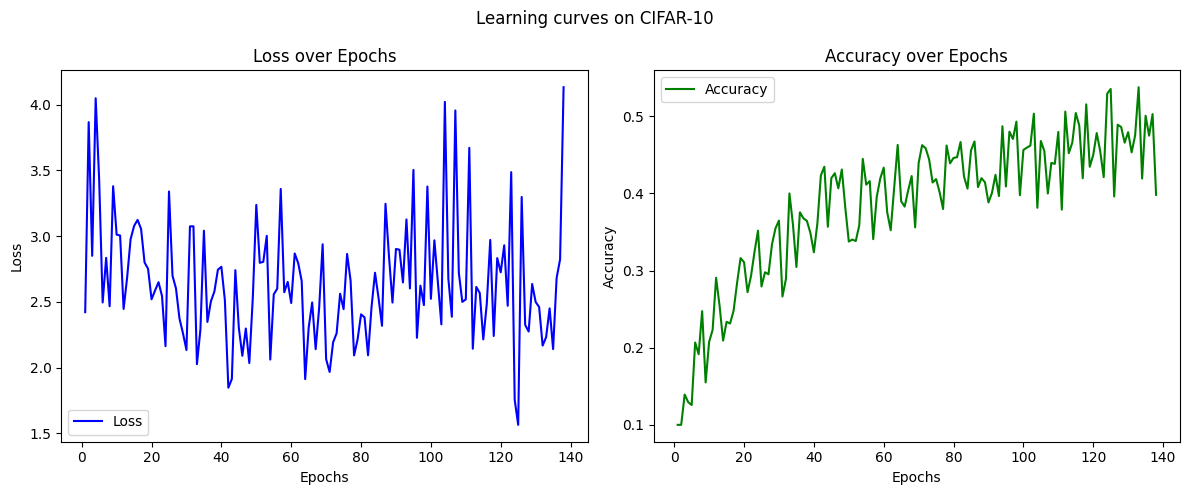

In [ ]:
gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_cifar,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_cifar.clients) * C),
    problem="cifar"
)

# save data
save_data(pool_cifar, losses, accuracies, elapsed, "dynhybrid_400_cifar")

plot_loss_accuracy(losses, accuracies, title="Learning curves on CIFAR-10")